In [215]:
import pandas as pd
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import folium
import requests
import json
import re
from branca.element import Template, MacroElement # 범례 생성을 위해 import


In [216]:
kb1 = pd.read_excel('영향조사/3715_경상북도_전체_영향조사_착정정보.xlsx', header=0)
kb2 = pd.read_excel('영향조사/3718_경상북도_전체_영향조사_대수성시험.xlsx', header=0)
kb3 = pd.read_excel('영향조사/3721_경상북도_전체_영향조사_암상특성.xlsx', header=0)
kb4 = pd.read_excel('영향조사/3725_경상북도_전체_영향조사_WHPA.xlsx', header=0)
kb5 = pd.read_excel('영향조사/3723_경상북도_전체_영향조사_수질검사일반.xlsx', header=0)

kn1 = pd.read_excel('영향조사/3921_경상남도_전체_영향조사_착정정보.xlsx', header=0)
kn2 = pd.read_excel('영향조사/3922_경상남도_전체_영향조사_대수성시험.xlsx', header=0)
kn3 = pd.read_excel('영향조사/3922_경상남도_전체_영향조사_암상특성.xlsx', header=0)
kn4 = pd.read_excel('영향조사/3922_경상남도_전체_영향조사_WHPA.xlsx', header=0)
kn5 = pd.read_excel('영향조사/3922_경상남도_전체_영향조사_수질검사일반.xlsx', header=0)

kw1 = pd.read_excel('영향조사/4011_강원특별자치도_전체_영향조사_착정정보.xlsx', header=0)
kw2 = pd.read_excel('영향조사/4011_강원특별자치도_전체_영향조사_대수성시험.xlsx', header=0)
kw3 = pd.read_excel('영향조사/4012_강원특별자치도_전체_영향조사_암상특성.xlsx', header=0)
kw4 = pd.read_excel('영향조사/4013_강원특별자치도_전체_영향조사_WHPA.xlsx', header=0)
kw5 = pd.read_excel('영향조사/4012_강원특별자치도_전체_영향조사_수질검사일반.xlsx', header=0)

c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\

In [ ]:
cities_filter = ['영주시','영덕군','울진군','삼척시','양양군', '함양군', '동해시', '속초시']

var_1 = ['영향조사번호', '시도', '시군구', '읍면동', '리', '굴착직경(mm)',
        '양수능력(㎥/일)', '취수계획량(㎥/일)', '경도','위도']
#  '심도(m)' 대수층 두께랑 상관 높다

var_2 = ['양수량','자연수위', '안정수위']
# '수위강하량' 안정수위랑 상관 높다

var_3 = ['비고']

var_4 =[ '투수량계수(㎡/일)','대수층두께(m)', '안정수위도달시간(분)','연평균강수량', '함양량_연평균', '향후개발가능량']

var_5 = ['수질검사종류코드']

join_key = '영향조사번호'

df_names = [f'{prefix}{i}' for prefix in ['kb', 'kn', 'kw'] for i in range(1, 5)]


dataframes = {
    'kb1': kb1, 'kb2': kb2, 'kb3': kb3, 'kb4': kb4, 'kb5': kb5,
    'kn1': kn1, 'kn2': kn2, 'kn3': kn3, 'kn4': kn4, 'kn5': kn5,
    'kw1': kw1, 'kw2': kw2, 'kw3': kw3, 'kw4': kw4, 'kw5': kw5,
    'kl1': kl1, 'kl2': kl2, 'kl3': kl3, 'kl4': kl4, 'kl5': kl5
}


In [ ]:
# --- 1단계: 그룹별(kb, kn, kw) Inner Join ---
print("--- 1단계: 그룹별 Inner Join 진행 ---")

# 그룹별로 순차적 병합을 수행하는 함수 정의
def integrate_group(prefix, dfs_dict, key):
    """
    지정된 prefix를 가진 데이터프레임들을 순차적으로 inner join합니다.
    중복되는 열에는 고유한 접미사를 붙여 MergeError를 방지합니다.
    """
    # 첫 번째 데이터프레임으로 시작합니다 (예: kb1)
    integrated_df = dfs_dict[f'{prefix}1'].copy()
    
    # 나머지 데이터프레임들(2, 3, 4)을 순차적으로 병합합니다.
    for i in range(2, 6):
        right_df_name = f'{prefix}{i}'
        right_df = dfs_dict[right_df_name]
        
        integrated_df = pd.merge(
            integrated_df,
            right_df,
            on=key,
            how='inner',
            # 중복 열에 대해 오른쪽 데이터프레임에만 접미사를 붙입니다.
            # 예: '위도' -> '위도_kb2'
            suffixes=('', f'_{right_df_name}')
        )
    return integrated_df

# 각 그룹에 대해 병합 함수 실행
kb_integrated = integrate_group('kb', dataframes, join_key)
kn_integrated = integrate_group('kn', dataframes, join_key)
kw_integrated = integrate_group('kw', dataframes, join_key)


# --- 2단계: 시군구 필터링 ---
print("--- 2단계: 시군구 필터링 진행 ---")

kb_filtered = kb_integrated[kb_integrated['시군구'].isin(cities_filter)].copy()
kn_filtered = kn_integrated[kn_integrated['시군구'].isin(cities_filter)].copy()
kw_filtered = kw_integrated[kw_integrated['시군구'].isin(cities_filter)].copy()


# --- 3단계: 최종 변수 선택 ---
print("--- 3단계: 최종 변수 선택 진행 ---")

# 최종적으로 남길 모든 변수 목록을 정의합니다.
# '시군구'와 같은 주소 정보도 포함할 수 있습니다.
final_cols_to_keep =  var_1 + var_2 + var_3 + var_4 + var_5

# 각 데이터프레임에 존재하는 열만 선택합니다.
kb_final = kb_filtered[[col for col in final_cols_to_keep if col in kb_filtered.columns]]
kn_final = kn_filtered[[col for col in final_cols_to_keep if col in kn_filtered.columns]]
kw_final = kw_filtered[[col for col in final_cols_to_keep if col in kw_filtered.columns]]


# --- 4단계: 통합된 데이터프레임 Row-bind ---
print("--- 4단계: 최종 데이터 Row-bind 진행 ---")

final_df = pd.concat([kb_final, kn_final, kw_final], ignore_index=True)


# --- 최종 결과 확인 ---
print("\n✔️ 최종 통합 결과:")
print(final_df.head())
print("\n✔️ 최종 데이터프레임 정보:")
final_df.info()




--- 1단계: 그룹별 Inner Join 진행 ---
--- 2단계: 시군구 필터링 진행 ---
--- 3단계: 최종 변수 선택 진행 ---
--- 4단계: 최종 데이터 Row-bind 진행 ---

✔️ 최종 통합 결과:
   영향조사번호    시도  시군구  읍면동    리  굴착직경(mm)  양수능력(㎥/일)  취수계획량(㎥/일)            경도  \
0    6375  경상북도  영주시  가흥동  NaN     250.0      250.0       220.0   128 35 47.9   
1    6375  경상북도  영주시  가흥동  NaN     250.0      250.0       220.0   128 35 47.9   
2    6375  경상북도  영주시  가흥동  NaN     250.0      250.0       220.0   128 35 47.9   
3   23637  경상북도  영주시  풍기읍  산법리     250.0      180.0       180.0  128 32 29.46   
4   23637  경상북도  영주시  풍기읍  산법리     250.0      180.0       180.0  128 32 29.46   

            위도  ...  자연수위   안정수위      비고 투수량계수(㎡/일)  대수층두께(m)  안정수위도달시간(분)  \
0   36 49 57.5  ...  3.28  45.15  토사층사력층      2.914      80.0       1800.0   
1   36 49 57.5  ...  3.28  45.15      연암      2.914      80.0       1800.0   
2   36 49 57.5  ...  3.28  45.15     풍화암      2.914      80.0       1800.0   
3  36 52 37.75  ...  2.90  50.80     토사층      1.079     144.0       1440.0 

In [22]:
final_df_unique = final_df.drop_duplicates(subset=['영향조사번호'])

# To modify the original DataFrame directly, use inplace=True
# final_df.drop_duplicates(subset=['영향조사번호'], inplace=True)

print(f"Original number of rows: {len(final_df)}")
print(f"Number of rows after removing duplicates: {len(final_df_unique)}")


Original number of rows: 955
Number of rows after removing duplicates: 270


In [151]:
cols_to_check = final_df_unique.columns.drop('리')


# 3. subset 파라미터를 사용하여 '리'를 제외한 열에 결측치가 있는 행 삭제
df_cleaned = final_df_unique.dropna(subset=cols_to_check)


# 4. 최종 결과 출력
print("\n--- '리' 제외 결측치 행 제거 후 ---")
print(df_cleaned)


--- '리' 제외 결측치 행 제거 후 ---
     영향조사번호       시도  시군구  읍면동    리  굴착직경(mm)  양수능력(㎥/일)  취수계획량(㎥/일)  \
0      6375     경상북도  영주시  가흥동  NaN     250.0      250.0       220.0   
3     23637     경상북도  영주시  풍기읍  산법리     250.0      180.0       180.0   
7     23636     경상북도  영주시  풍기읍  미곡리     250.0      180.0       180.0   
11    20259     경상북도  영주시  풍기읍  전구리     250.0      115.0       105.0   
14    20412     경상북도  영주시  이산면  신암리     250.0      170.0       150.0   
..      ...      ...  ...  ...  ...       ...        ...         ...   
888    9581  강원특별자치도  삼척시  조비동  NaN     125.0      150.0       150.0   
891    9612  강원특별자치도  삼척시  원덕읍  NaN     200.0      150.0       150.0   
895    9669  강원특별자치도  삼척시  원덕읍  옥원리     200.0      150.0       150.0   
899    9572  강원특별자치도  삼척시  원덕읍  산양리     200.0      550.0       550.0   
909    9571  강원특별자치도  삼척시  하장면  둔전리     275.0      200.0       200.0   

               경도           위도  ...   자연수위    안정수위      비고 투수량계수(㎡/일)  \
0     128 35 47.9   36 49 57.5  ...

In [36]:
df_cleaned.columns

Index(['영향조사번호', '시도', '시군구', '읍면동', '리', '굴착직경(mm)', '양수능력(㎥/일)',
       '취수계획량(㎥/일)', '경도', '위도', '양수량', '자연수위', '안정수위', '비고', '투수량계수(㎡/일)',
       '대수층두께(m)', '안정수위도달시간(분)', '연평균강수량', '함양량_연평균', '향후개발가능량', '수질검사종류코드'],
      dtype='object')

In [25]:
file_path = 'df_cleaned.csv'
df_cleaned.to_csv(file_path, index=False, encoding='utf-8-sig')

eda 시각화

In [152]:
df_cleaned = df_cleaned[df_cleaned['양수량']<=600]
df_cleaned = df_cleaned[df_cleaned['취수계획량(㎥/일)']<=600]



--- 2. 데이터 기본 정보 ---

[데이터 정보 (info)]
<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 0 to 909
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   영향조사번호       192 non-null    int64  
 1   시도           192 non-null    object 
 2   시군구          192 non-null    object 
 3   읍면동          192 non-null    object 
 4   리            152 non-null    object 
 5   굴착직경(mm)     192 non-null    float64
 6   양수능력(㎥/일)    192 non-null    float64
 7   취수계획량(㎥/일)   192 non-null    float64
 8   경도           192 non-null    object 
 9   위도           192 non-null    object 
 10  양수량          192 non-null    float64
 11  자연수위         192 non-null    float64
 12  안정수위         192 non-null    float64
 13  비고           192 non-null    object 
 14  투수량계수(㎡/일)   192 non-null    float64
 15  대수층두께(m)     192 non-null    float64
 16  안정수위도달시간(분)  192 non-null    float64
 17  연평균강수량       192 non-null    float64
 18  함양량_연평균      192

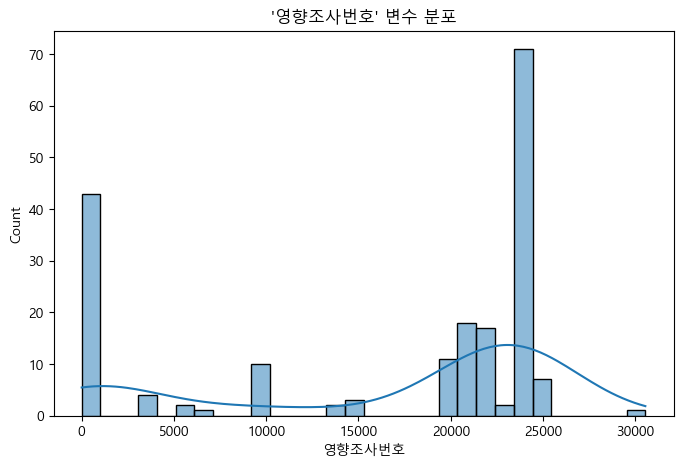

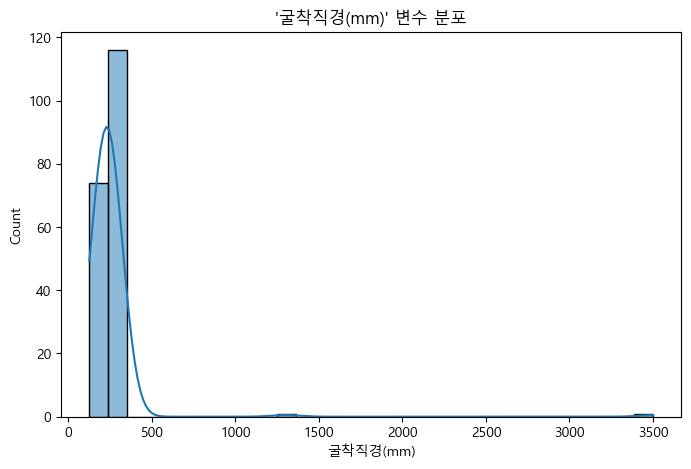

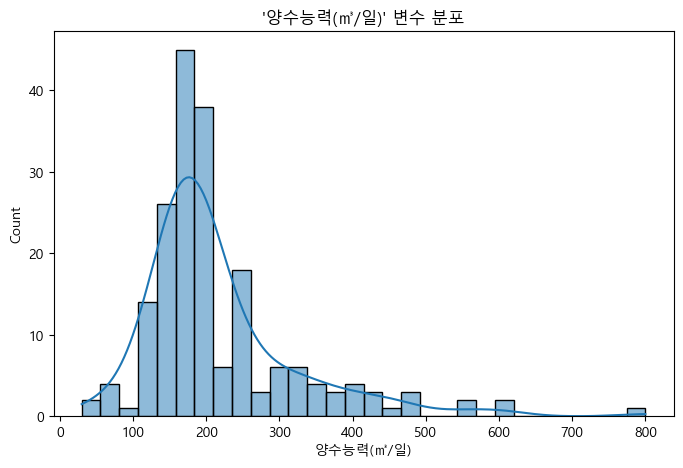

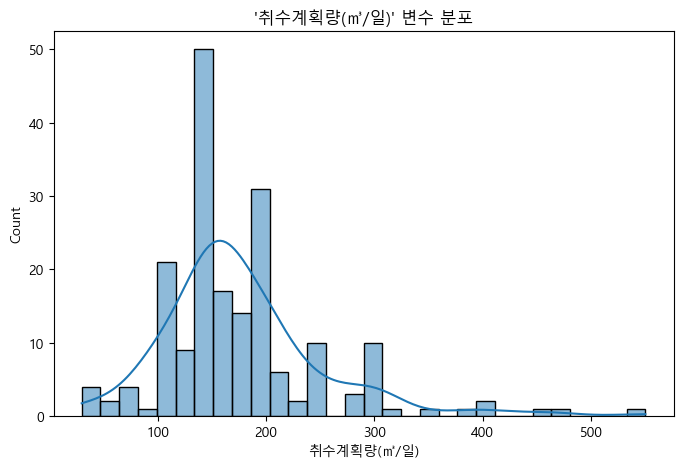

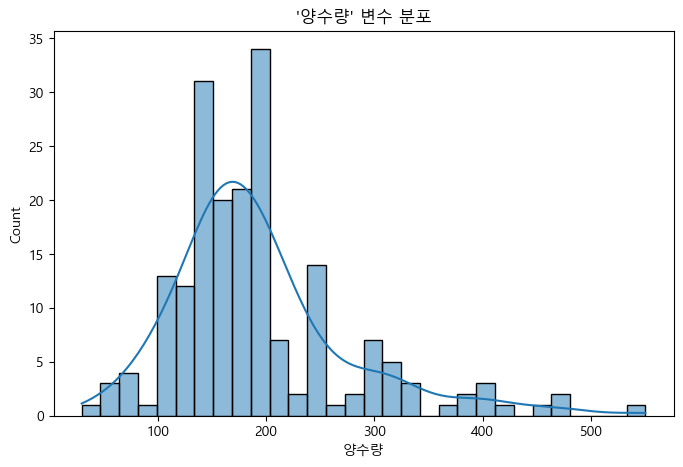

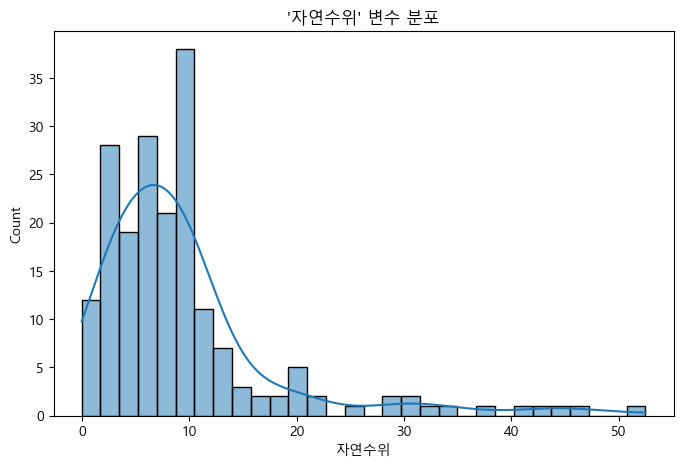

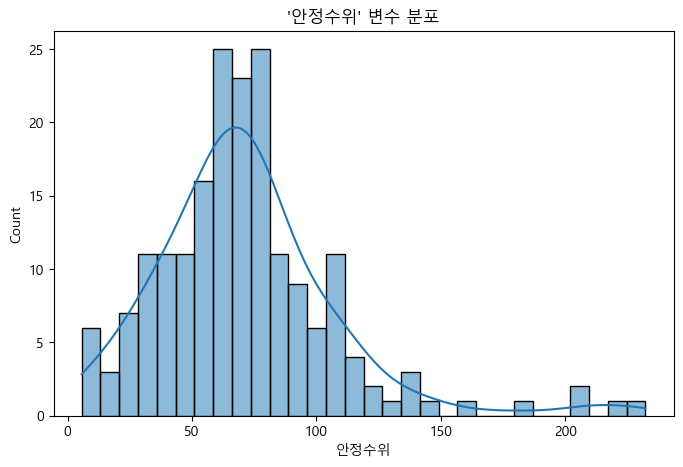

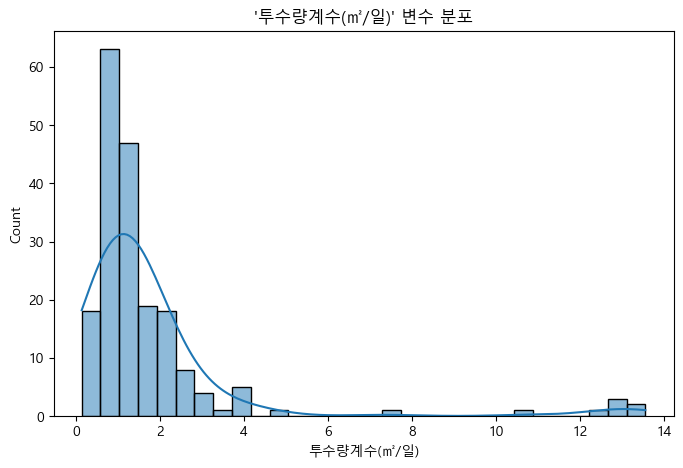

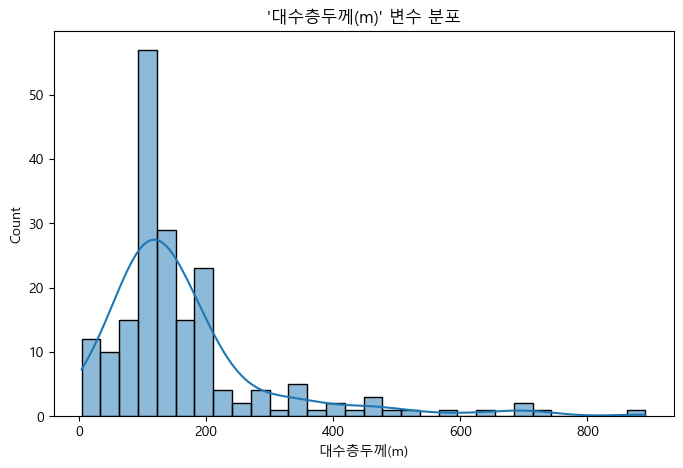

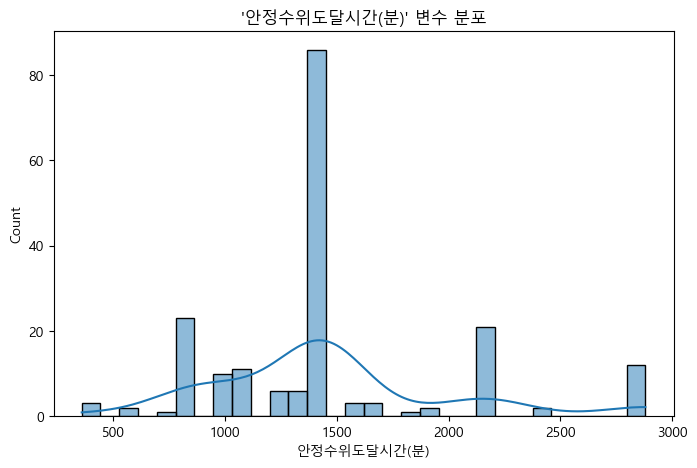

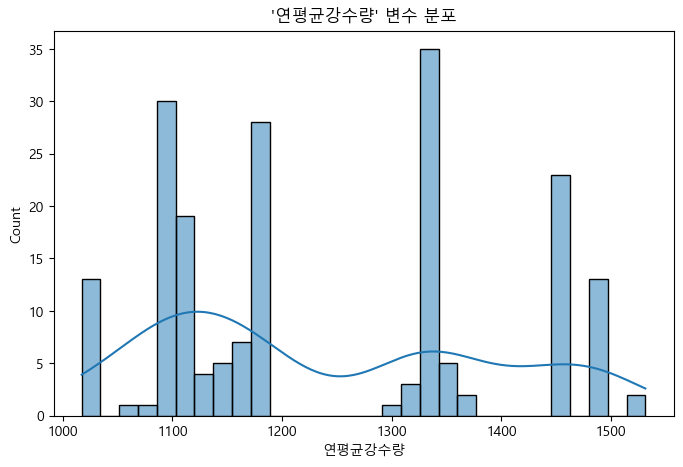

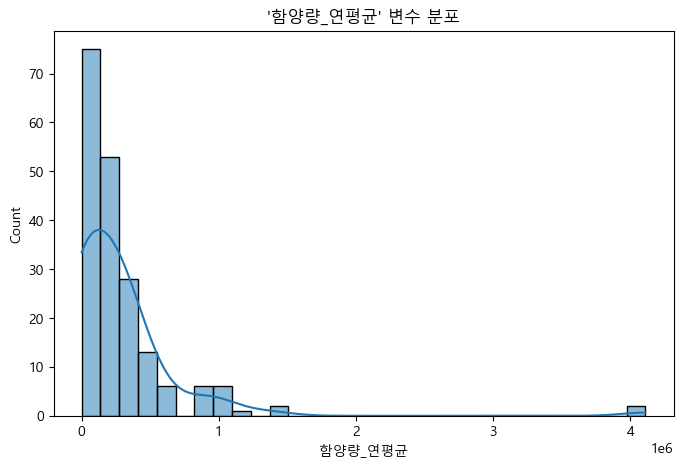

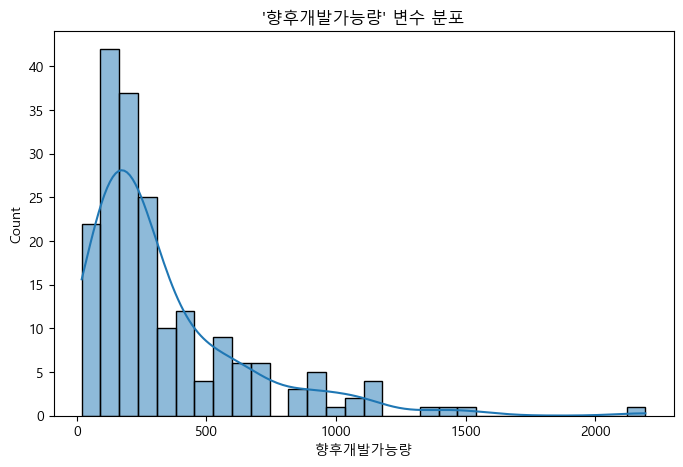


수치형 변수 간의 상관관계를 히트맵으로 확인합니다.


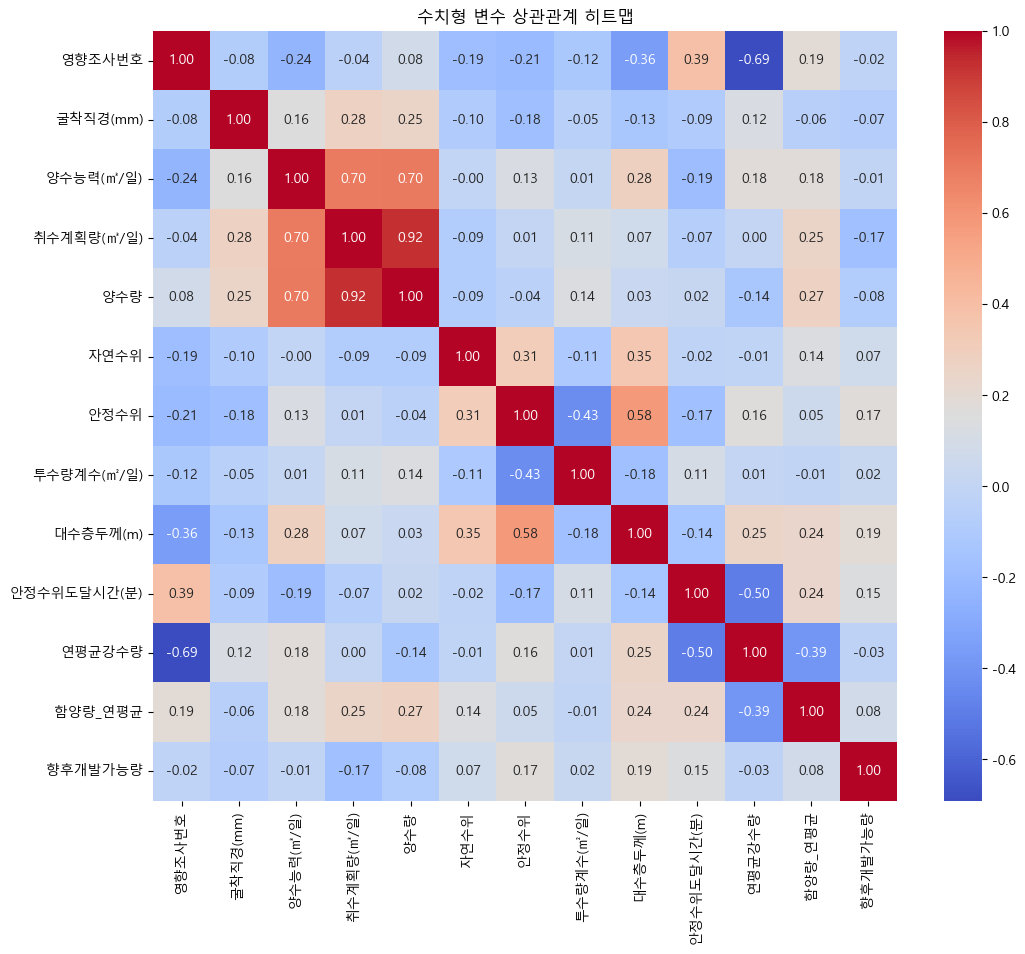


--- 5. 범주형 변수 EDA ---
각 범주형 변수의 빈도를 막대 그래프로 확인합니다.


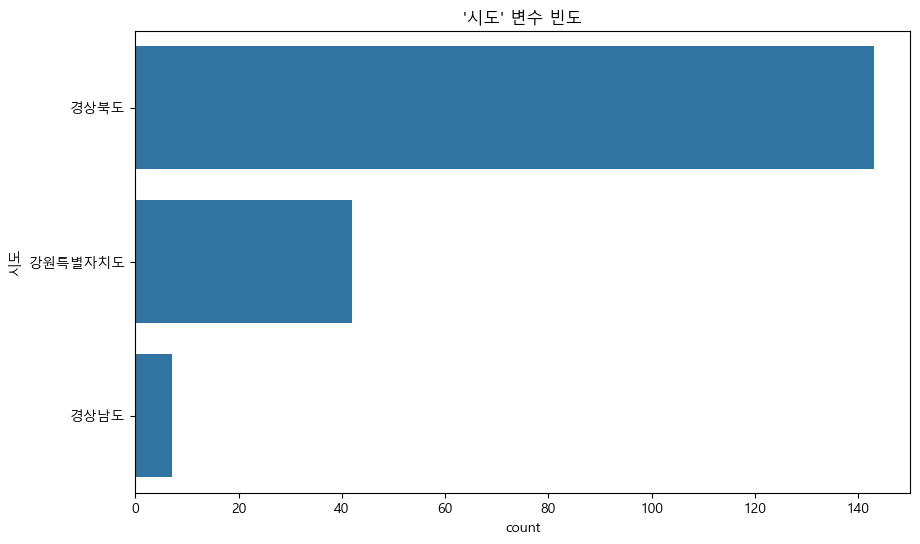

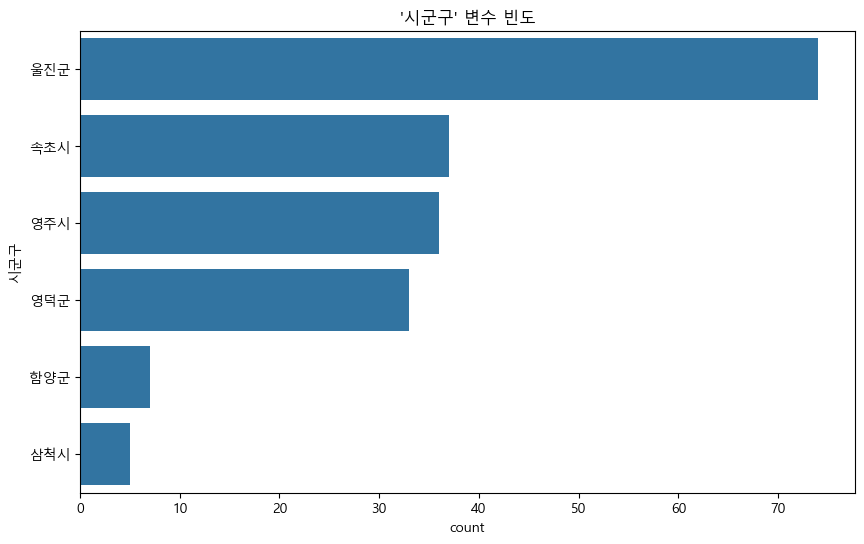

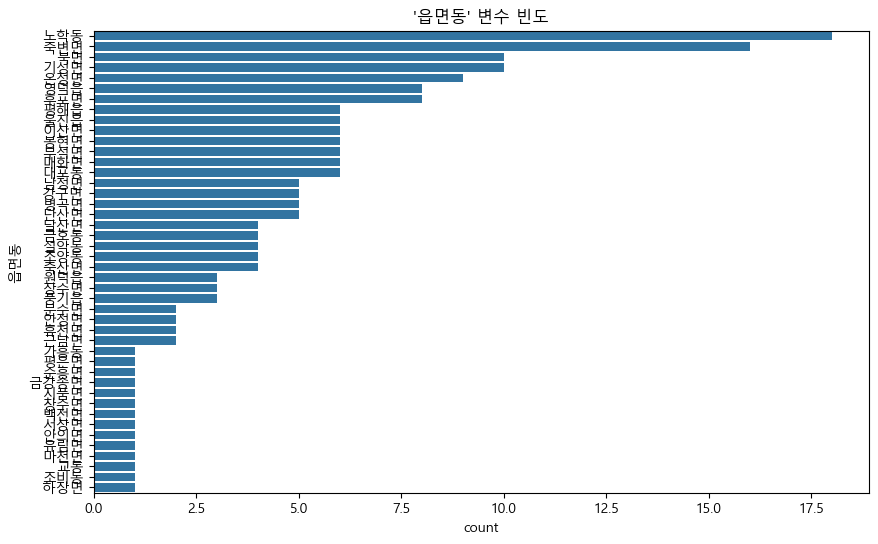

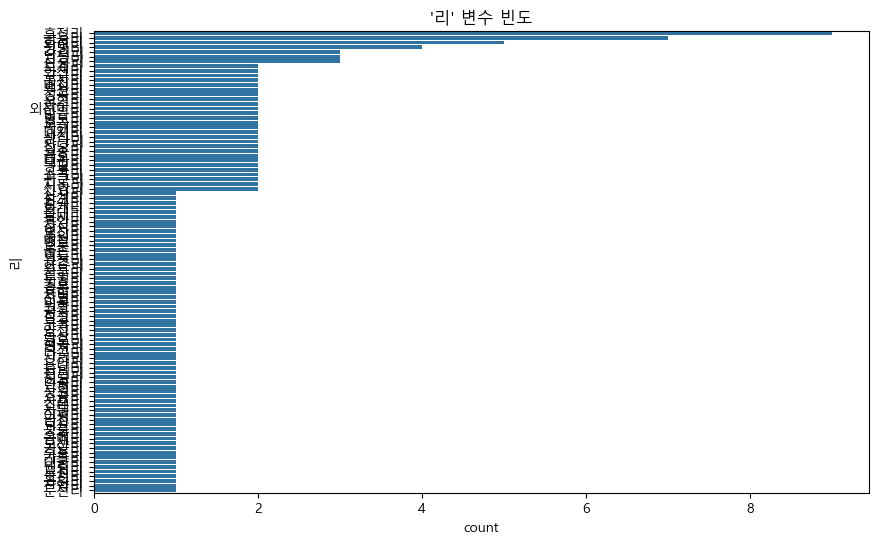

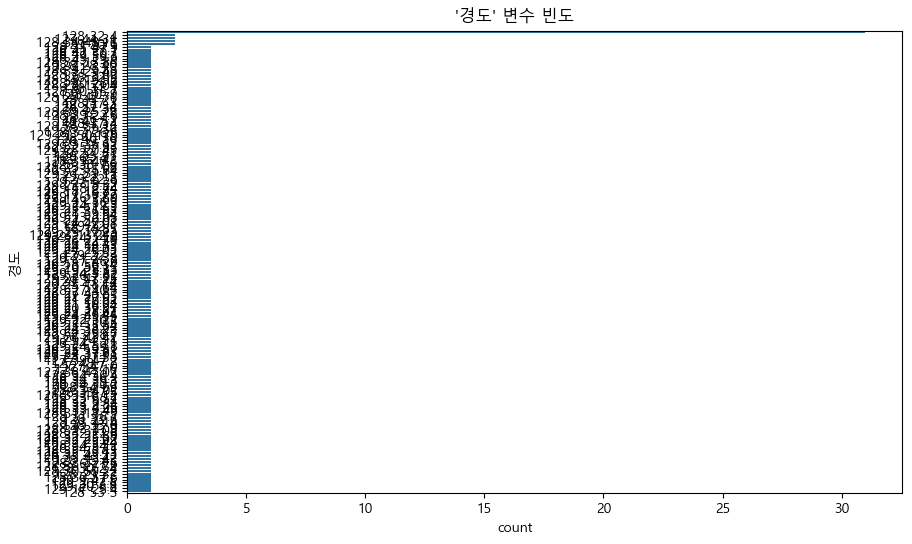

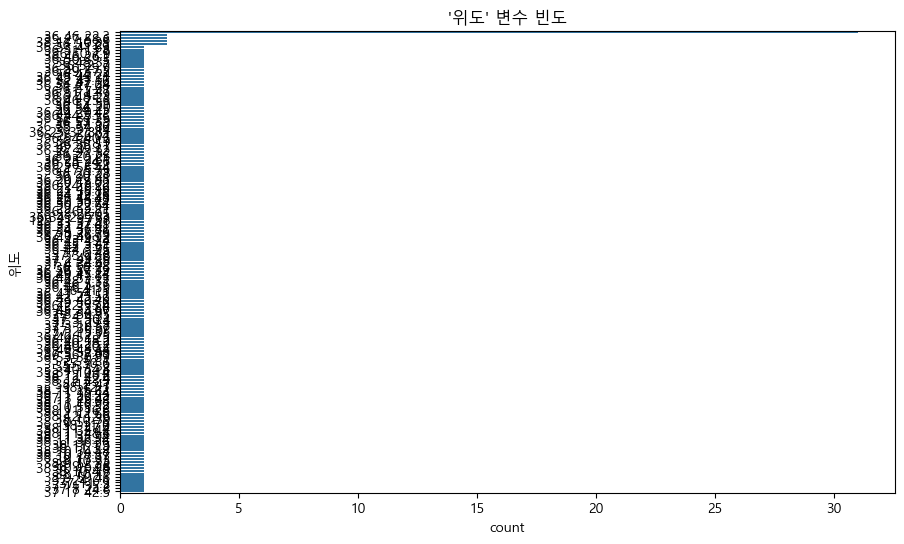

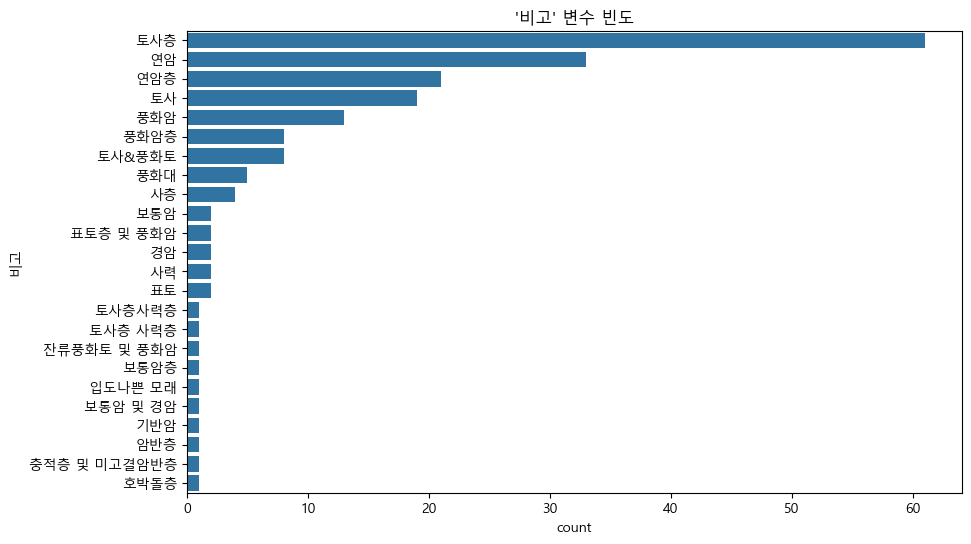

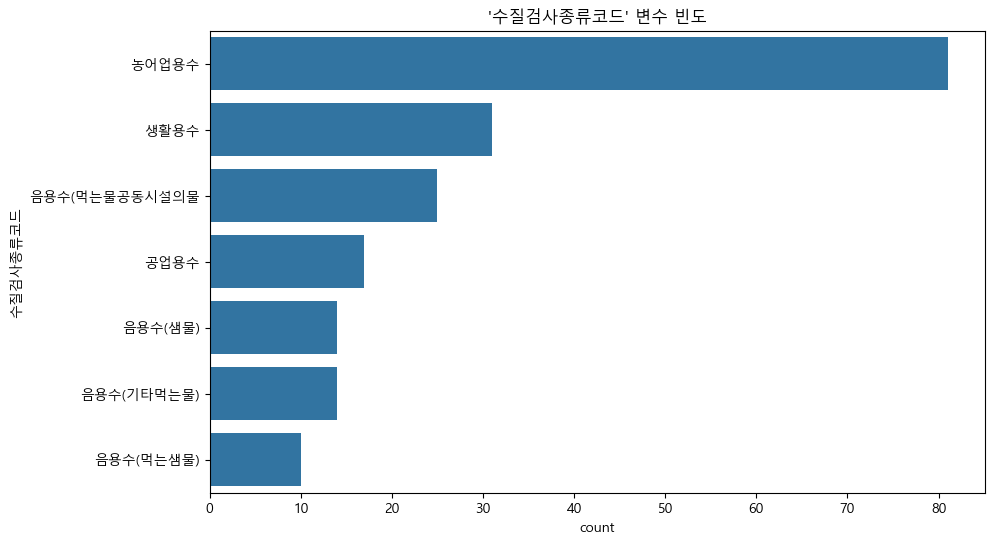

In [40]:
# --- 0. 기본 설정 ---
# 한글 폰트 설정 (Windows: Malgun Gothic, macOS: AppleGothic)
try:
    font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    plt.rc('font', family=font_name)
except FileNotFoundError:
    print("Malgun Gothic font not found. Please check your font path.")
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


df = df_cleaned


# --- 2. 데이터 기본 정보 확인 ---
print("\n--- 2. 데이터 기본 정보 ---")
print("\n[데이터 정보 (info)]")
df.info()

print("\n[수치형 데이터 기술 통계량 (describe)]")
print(df.describe())

print("\n[범주형 데이터 기술 통계량 (describe)]")
print(df.describe(include=['object']))


# --- 3. 결측치 확인 ---
print("\n--- 3. 결측치 확인 ---")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


# --- 4. 수치형 변수 EDA ---
print("\n--- 4. 수치형 변수 EDA ---")
# 자동으로 수치형 변수만 선택
numeric_features = df.select_dtypes(include=np.number).columns.tolist()

# 4-1. 각 수치형 변수의 분포 (히스토그램)
print("각 수치형 변수의 분포를 히스토그램으로 확인합니다.")
for col in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'\'{col}\' 변수 분포')
    plt.show()

# 4-2. 수치형 변수 간의 상관관계 (히트맵)
print("\n수치형 변수 간의 상관관계를 히트맵으로 확인합니다.")
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('수치형 변수 상관관계 히트맵')
plt.show()


# --- 5. 범주형 변수 EDA ---
print("\n--- 5. 범주형 변수 EDA ---")
# 자동으로 범주형 변수만 선택
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# 5-1. 각 범주형 변수의 빈도 (막대 그래프)
print("각 범주형 변수의 빈도를 막대 그래프로 확인합니다.")
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'\'{col}\' 변수 빈도')
    plt.show()


k-means 진행

In [153]:
df_cleaned.columns

Index(['영향조사번호', '시도', '시군구', '읍면동', '리', '굴착직경(mm)', '양수능력(㎥/일)',
       '취수계획량(㎥/일)', '경도', '위도', '양수량', '자연수위', '안정수위', '비고', '투수량계수(㎡/일)',
       '대수층두께(m)', '안정수위도달시간(분)', '연평균강수량', '함양량_연평균', '향후개발가능량', '수질검사종류코드'],
      dtype='object')

'양수량', '자연수위', '안정수위', '투수량계수(㎡/일)','대수층두께(m)', '연평균강수량', '함양량_연평균', '수질검사종류코드'

In [154]:
# 2-1. 범주형 변수 처리 (Target Encoding)
if '수질검사종류코드' in df_cleaned.columns and '양수량' in df_cleaned.columns:
    # '음용수' 관련 카테고리를 하나로 통합합니다.
    df_cleaned.loc[df_cleaned['수질검사종류코드'].str.contains('음용수', na=False), '수질검사종류코드'] = '음용수'
    
    # '양수량'을 기준으로 각 카테고리의 평균값을 계산합니다.
    target_mean = df_cleaned.groupby('수질검사종류코드')['양수량'].mean()
    
    # 계산된 평균값으로 카테고리를 매핑하여 새로운 수치형 변수를 생성합니다.
    df_cleaned['수질검사_encoded'] = df_cleaned['수질검사종류코드'].map(target_mean)


In [155]:
knncol = ['양수량', '자연수위', '안정수위','수질검사_encoded']
#, '함양량_연평균', '향후개발가능량'

In [156]:
df_for_clustering = df_cleaned.copy()



--- 클러스터 개수(k)별 실루엣 계수 계산 ---
k = 2, 실루엣 계수 = 0.3444
k = 3, 실루엣 계수 = 0.3878
k = 4, 실루엣 계수 = 0.4158
k = 5, 실루엣 계수 = 0.4345
k = 6, 실루엣 계수 = 0.3648
k = 7, 실루엣 계수 = 0.3805
k = 8, 실루엣 계수 = 0.3161
k = 9, 실루엣 계수 = 0.2869
k = 10, 실루엣 계수 = 0.2829


c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn

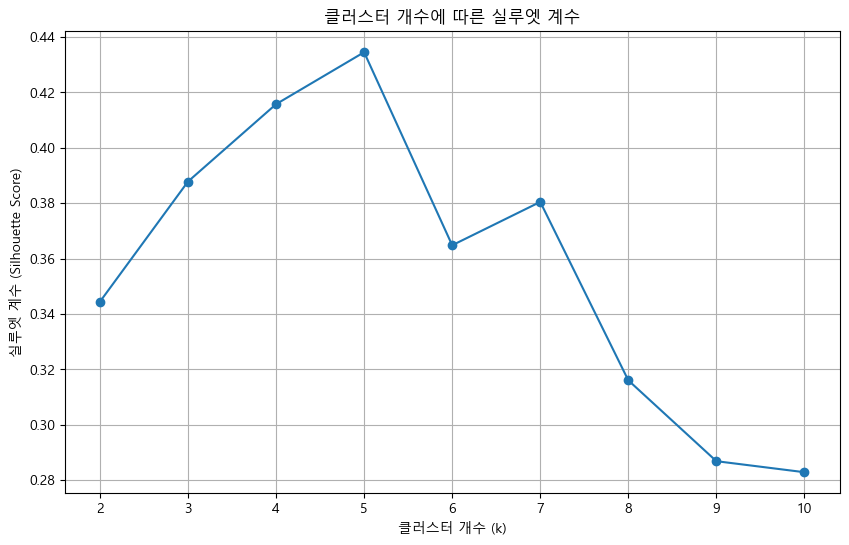


✔️ 실루엣 계수가 가장 높은 최적의 클러스터 개수(k)는 5 입니다.

--- 각 클러스터의 데이터 개수 ---
cluster
0    22
1    69
2    71
3    12
4    18
Name: count, dtype: int64


c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [157]:
# 분석에 사용할 최종 변수 목록 업데이트 (원본 변수 제외, 변환된 변수 추가)
df_for_clustering = df_for_clustering[knncol_final]


# 2-4. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_for_clustering)


# --- 3. 실루엣 계수를 이용한 최적의 K 찾기 ---
k_range = range(2, 11)
silhouette_scores = []

print("\n--- 클러스터 개수(k)별 실루엣 계수 계산 ---")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(X_scaled)
    if len(np.unique(clusters)) > 1:
        score = silhouette_score(X_scaled, clusters)
        silhouette_scores.append(score)
        print(f'k = {k}, 실루엣 계수 = {score:.4f}')
    else:
        silhouette_scores.append(-1)
        print(f'k = {k}, 클러스터가 1개만 생성되어 점수 계산 불가')

# --- 4. 실루엣 계수 시각화 ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-')
plt.title('클러스터 개수에 따른 실루엣 계수')
plt.xlabel('클러스터 개수 (k)')
plt.ylabel('실루엣 계수 (Silhouette Score)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


# --- 5. 최적의 K로 최종 클러스터링 수행 ---
if silhouette_scores and max(silhouette_scores) != -1:
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f'\n✔️ 실루엣 계수가 가장 높은 최적의 클러스터 개수(k)는 {optimal_k} 입니다.')

    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    df_for_clustering['cluster'] = kmeans.fit_predict(X_scaled)
    df_cleaned['cluster'] = kmeans.fit_predict(X_scaled)

    print('\n--- 각 클러스터의 데이터 개수 ---')
    print(df_for_clustering['cluster'].value_counts().sort_index())
else:
    print("\n❌ 클러스터링을 수행할 데이터가 없거나 유효한 클러스터를 찾지 못했습니다.")



사용변수 : '양수량', '자연수위', '안정수위','수질검사_endcoded'

이용해 클러스터 분류모델 작성 후 강릉 데이터 유형예측 시행


교차 검증 정확도 점수: [0.94871795 1.         1.         0.97368421 0.94736842]
평균 교차 검증 정확도: 0.9740 (+/- 0.0232)

[교차 검증 기반 분류 리포트]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.99      1.00      0.99        69
           2       1.00      0.99      0.99        71
           3       1.00      0.83      0.91        12
           4       0.94      0.94      0.94        18

    accuracy                           0.97       192
   macro avg       0.96      0.94      0.95       192
weighted avg       0.98      0.97      0.97       192


[교차 검증 기반 혼동 행렬 (Confusion Matrix)]


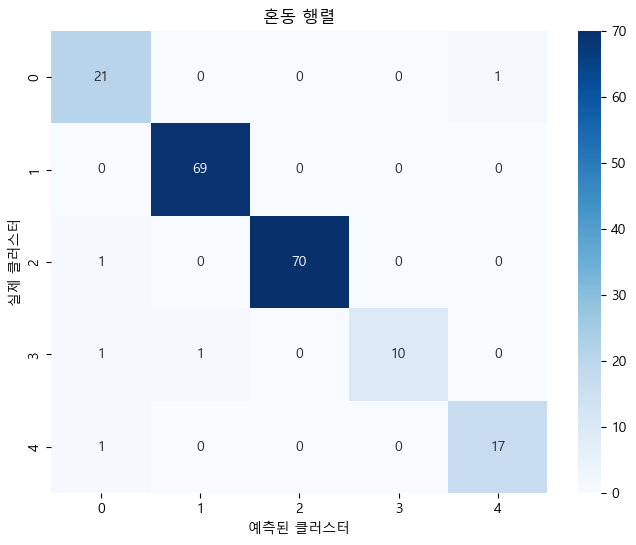


--- 클러스터 예측을 위한 변수 중요도 ---
        feature  importance
3  수질검사_encoded    0.402481
0           양수량    0.262529
2          안정수위    0.197489
1          자연수위    0.137502


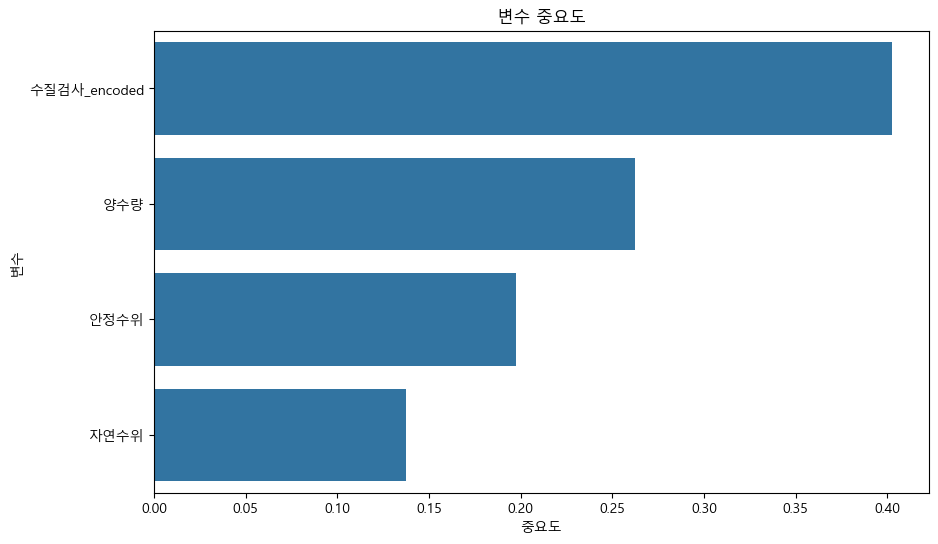

In [163]:
# 1-1. 분석에 사용할 변수 목록 정의
features = ['양수량', '자연수위', '안정수위', '수질검사_encoded']
target = 'cluster'

# 1-2. 필요한 변수만 선택하고 결측치 제거
model_df = df_cleaned[features + [target]].copy()

# 1-3. 'cluster' 변수를 범주형(category)으로 변환
model_df[target] = model_df[target].astype('category')


# --- 2. 모델 학습 및 교차 검증 준비 ---
# 설명 변수(X)와 목표 변수(Y) 분리
X = model_df[features]
y = model_df[target]

# 랜덤 포레스트 분류기 모델 생성
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 교차 검증 전략 설정 (5-fold Stratified CV)
# StratifiedKFold는 각 폴드마다 클러스터의 비율을 동일하게 유지해 줍니다.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# --- 3. 교차 검증 기반 모델 성능 평가 ---

# 3-1. 교차 검증 정확도 점수 계산
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print(f"\n교차 검증 정확도 점수: {cv_scores}")
print(f"평균 교차 검증 정확도: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 3-2. 교차 검증 기반 예측 수행
# 각 데이터 포인트가 테스트 데이터로 사용될 때의 예측값을 생성합니다.
y_pred_cv = cross_val_predict(model, X, y, cv=cv)

# 3-3. 분류 리포트 출력
print("\n[교차 검증 기반 분류 리포트]")
print(classification_report(y, y_pred_cv))

# 3-4. 혼동 행렬 시각화
print("\n[교차 검증 기반 혼동 행렬 (Confusion Matrix)]")
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(8, 6))
# y.cat.categories를 사용하여 범주 순서에 맞는 라벨을 가져옵니다.
labels = y.cat.categories
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('혼동 행렬')
plt.xlabel('예측된 클러스터')
plt.ylabel('실제 클러스터')
plt.show()


# --- 4. 변수 중요도 확인 ---
# 전체 데이터를 사용하여 모델을 최종적으로 학습시킨 후 변수 중요도를 확인합니다.
model.fit(X, y)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- 클러스터 예측을 위한 변수 중요도 ---")
print(feature_importance)

# 변수 중요도를 막대 그래프로 시각화합니다.
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('변수 중요도')
plt.xlabel('중요도')
plt.ylabel('변수')
plt.show()

In [130]:
kl1 = pd.read_excel('영향조사/2639_강원특별자치도_강릉시_영향조사_착정정보.xlsx', header=0)
kl2 = pd.read_excel('영향조사/2639_강원특별자치도_강릉시_영향조사_대수성시험.xlsx', header=0)
kl3 = pd.read_excel('영향조사/4012_강원특별자치도_전체_영향조사_암상특성.xlsx', header=0)
kl4 = pd.read_excel('영향조사/2639_강원특별자치도_강릉시_영향조사_암상특성.xlsx', header=0)
kl5 = pd.read_excel('영향조사/2639_강원특별자치도_강릉시_영향조사_수질검사일반.xlsx', header=0)

c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\samjw\miniconda3\envs\gloenv\Lib\site-packages\

In [184]:
kl_integrated = integrate_group('kl', dataframes, join_key)
final_cols_to_keep = ['영향조사번호','양수량', '자연수위', '안정수위','수질검사종류코드','위도','경도','읍면동','리']
kl_final = kl_integrated[[col for col in final_cols_to_keep if col in kw_integrated.columns]]


In [185]:
kl_unique = kl_final.drop_duplicates(subset=['영향조사번호'])

# To modify the original DataFrame directly, use inplace=True
# final_df.drop_duplicates(subset=['영향조사번호'], inplace=True)

print(f"Original number of rows: {len(kl_final)}")
print(f"Number of rows after removing duplicates: {len(kl_unique)}")


Original number of rows: 1568
Number of rows after removing duplicates: 112


In [187]:
cols_to_check = kl_unique.columns.drop(['리','읍면동','위도','경도'])


# 3. subset 파라미터를 사용하여 '리'를 제외한 열에 결측치가 있는 행 삭제
kl_cleaned = kl_unique.dropna(subset=cols_to_check)


# 4. 최종 결과 출력
print(kl_cleaned)

      영향조사번호  양수량   자연수위    안정수위 수질검사종류코드           위도            경도  읍면동  \
16      5631   80   8.43   95.66     생활용수     37 45 32     128 52 46   교동   
73      9753  100  17.72   77.15     생활용수   37 45 40.4   128 52 38.9   교동   
82      5692  230   5.30   74.08     생활용수   37 46 6.59   128 53 9.22   교동   
98      5693  310  31.50  158.25     생활용수   37 46 8.22  128 53 10.13   교동   
123     5699  500   8.00   28.45     생활용수   37 46 6.59   128 53 9.22   교동   
...      ...  ...    ...     ...      ...          ...           ...  ...   
1443    5627  150  12.00   68.30  음용수(샘물)   37 47 22.5   128 48 16.2  사천면   
1459    5634  200   6.50   81.48     생활용수   37 52 18.8    128 50 2.1  연곡면   
1484    5635  150   4.70   72.52     생활용수   37 52 18.4     128 50 .8  연곡면   
1500    5636  100   3.00    5.16     생활용수  37 52 18.35  128 49 58.25  연곡면   
1504    5624  200   3.72   40.44    농어업용수     37 50 48     128 50 46  연곡면   

         리  
16     NaN  
73     NaN  
82     NaN  
98     NaN  
123    NaN

In [188]:
# 2-1. 범주형 변수 처리 (Target Encoding)
if '수질검사종류코드' in kl_cleaned.columns and '양수량' in kl_cleaned.columns:
    # '음용수' 관련 카테고리를 하나로 통합합니다.
    kl_cleaned.loc[kl_cleaned['수질검사종류코드'].str.contains('음용수', na=False), '수질검사종류코드'] = '음용수'
    
    # '양수량'을 기준으로 각 카테고리의 평균값을 계산합니다.
    target_mean = kl_cleaned.groupby('수질검사종류코드')['양수량'].mean()
    
    # 계산된 평균값으로 카테고리를 매핑하여 새로운 수치형 변수를 생성합니다.
    kl_cleaned['수질검사_encoded'] = kl_cleaned['수질검사종류코드'].map(target_mean)


C:\Users\samjw\AppData\Local\Temp\ipykernel_28248\927964551.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kl_cleaned['수질검사_encoded'] = kl_cleaned['수질검사종류코드'].map(target_mean)


In [189]:
# --- 5. 새로운 데이터(kl_cleaned)에 대한 예측 수행 ---

# 5-1. 예측에 사용할 변수만 선택하고 결측치 처리
# 학습에 사용된 features와 동일한 순서로 열을 선택해야 합니다.
kl_features = kl_cleaned[features].dropna()

# 5-2. 학습된 모델로 클러스터 예측
kl_predictions = model.predict(kl_features)

# 5-3. 예측 결과를 원본 데이터에 추가
# dropna()로 인해 인덱스가 달라졌을 수 있으므로, kl_features의 인덱스를 사용합니다.
kl_cleaned.loc[kl_features.index, 'predicted_cluster'] = kl_predictions

print("\n--- 새로운 데이터에 대한 예측 결과 ---")
print(kl_cleaned.head())


--- 새로운 데이터에 대한 예측 결과 ---
     영향조사번호  양수량   자연수위    안정수위 수질검사종류코드          위도            경도 읍면동    리  \
16     5631   80   8.43   95.66     생활용수    37 45 32     128 52 46  교동  NaN   
73     9753  100  17.72   77.15     생활용수  37 45 40.4   128 52 38.9  교동  NaN   
82     5692  230   5.30   74.08     생활용수  37 46 6.59   128 53 9.22  교동  NaN   
98     5693  310  31.50  158.25     생활용수  37 46 8.22  128 53 10.13  교동  NaN   
123    5699  500   8.00   28.45     생활용수  37 46 6.59   128 53 9.22  교동  NaN   

     수질검사_encoded  predicted_cluster  
16     230.419355                2.0  
73     230.419355                2.0  
82     230.419355                2.0  
98     230.419355                2.0  
123    230.419355                0.0  


C:\Users\samjw\AppData\Local\Temp\ipykernel_28248\2592848442.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kl_cleaned.loc[kl_features.index, 'predicted_cluster'] = kl_predictions


In [217]:
# --- 2. DMS to DD 변환 함수 (안정성 강화) ---
def dms_to_dd_robust(dms_str):
    """
    공백, 특수 문자 등 다양한 구분자를 처리할 수 있는 안정적인 DMS to DD 변환 함수.
    """
    try:
        parts = [float(p) for p in re.split(r'[^\d.]+', str(dms_str)) if p]
        if len(parts) == 3:
            d, m, s = parts
            if not (33 <= d <= 132):
                return np.nan
            dd = d + m/60 + s/3600
            return dd
        return np.nan
    except (ValueError, TypeError):
        return np.nan

# '위도'와 '경도' 열에 새로운 함수를 적용하여 십진수 좌표 열 생성
kl_cleaned['lat_dd'] = kl_cleaned['위도'].apply(dms_to_dd_robust)
kl_cleaned['lon_dd'] = kl_cleaned['경도'].apply(dms_to_dd_robust)

# 변환 후 결측값이 있는 행은 제거
kl_cleaned.dropna(subset=['lat_dd', 'lon_dd'], inplace=True)


# --- 3. 지도 생성 ---
# 강릉시청을 중심으로 지도 생성 (위도: 37.7555, 경도: 128.8741)
m = folium.Map(location=[37.7555, 128.8741], zoom_start=12)

# 클러스터 값에 따라 색상을 매핑하는 딕셔너리
color_map = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'purple',
    4: 'orange',
    -1: 'gray' # Noise
}


# --- 4. 지도에 점 찍기 ---
# 데이터프레임의 각 행을 순회하며 지도에 점을 추가합니다.
for idx, row in kl_cleaned.iterrows():
    cluster_num = row['predicted_cluster']
    cluster_int = int(cluster_num) # float을 int로 변환
    
    # 팝업에 표시될 라벨 생성
    if cluster_int == -1:
        popup_label = 'Noise'
    else:
        popup_label = f'유형 {cluster_int + 1}'

    folium.CircleMarker(
        location=[row['lat_dd'], row['lon_dd']],
        radius=10,
        color=color_map.get(cluster_int, 'black'),
        fill=True,
        fill_color=color_map.get(cluster_int, 'black'),
        fill_opacity=0.7,
        popup=popup_label # 수정된 라벨을 팝업에 적용
    ).add_to(m)


# --- 5. 범례(Legend) 추가 (Branca 라이브러리 사용) ---
# 범례를 표현할 Jinja2 템플릿을 정의합니다.
template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 150px; height: auto; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;">
<b>클러스터 범례</b><br>
{% for label, color in this.colors.items() %}
<i style="background:{{ color }}; width:15px; height:15px; display:inline-block; margin-right:5px; border:1px solid grey;"></i> {{ label }}<br>
{% endfor %}
</div>
{% endmacro %}
"""

# 범례에 표시할 항목들을 만듭니다.
legend_items = {}
for cluster_num in sorted(kl_cleaned['predicted_cluster'].unique()):
    cluster_int = int(cluster_num) # float을 int로 변환
    
    # 범례에 표시될 라벨 생성
    if cluster_int == -1:
        label = 'Noise'
    else:
        label = f'유형 {cluster_int + 1}'
        
    legend_items[label] = color_map.get(cluster_int, 'black')

# MacroElement를 사용하여 범례를 생성합니다.
macro = MacroElement()
macro._template = Template(template)
macro.colors = legend_items

# 지도에 범례를 추가합니다.
m.add_child(macro)


# --- 6. 지도 저장 ---
# 결과를 HTML 파일로 저장합니다.
map_file_path = 'gangneung_map.html'
m.save(map_file_path)

print(f"✔️ 지도가 '{map_file_path}' 파일로 성공적으로 저장되었습니다.")
print("해당 파일을 웹 브라우저로 열어 확인하세요.")


✔️ 지도가 'gangneung_map.html' 파일로 성공적으로 저장되었습니다.
해당 파일을 웹 브라우저로 열어 확인하세요.


C:\Users\samjw\AppData\Local\Temp\ipykernel_28248\309097763.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kl_cleaned['lat_dd'] = kl_cleaned['위도'].apply(dms_to_dd_robust)
C:\Users\samjw\AppData\Local\Temp\ipykernel_28248\309097763.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kl_cleaned['lon_dd'] = kl_cleaned['경도'].apply(dms_to_dd_robust)
C:\Users\samjw\AppData\Local\Temp\ipykernel_28248\309097763.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


각 클러스터에 대한 eda 통한 차이점 확인

--- 1. 클러스터별 데이터 개수 ---
cluster_label
유형 1    22
유형 2    69
유형 3    71
유형 4    12
유형 5    18
Name: count, dtype: int64
--------------------------------------------------
--- 2. 클러스터별 수치형 변수 분포 비교 ---

[클러스터별 기술 통계량]
                양수량                                                      \
              count        mean        std    min     25%    50%    75%   
cluster_label                                                             
유형 1           22.0  369.181818  71.253830  290.0  316.25  350.0  400.0   
유형 2           69.0  147.565217  42.529048   30.0  120.00  150.0  170.0   
유형 3           71.0  196.492958  32.537395  150.0  175.00  200.0  200.0   
유형 4           12.0  171.833333  89.708450   70.0  100.00  150.0  225.0   
유형 5           18.0  163.888889  63.875696  100.0  112.50  150.0  222.5   

                      자연수위             ...    연평균강수량         함양량_연평균  \
                 max count       mean  ...       75%     max   count   
cluster_label                          

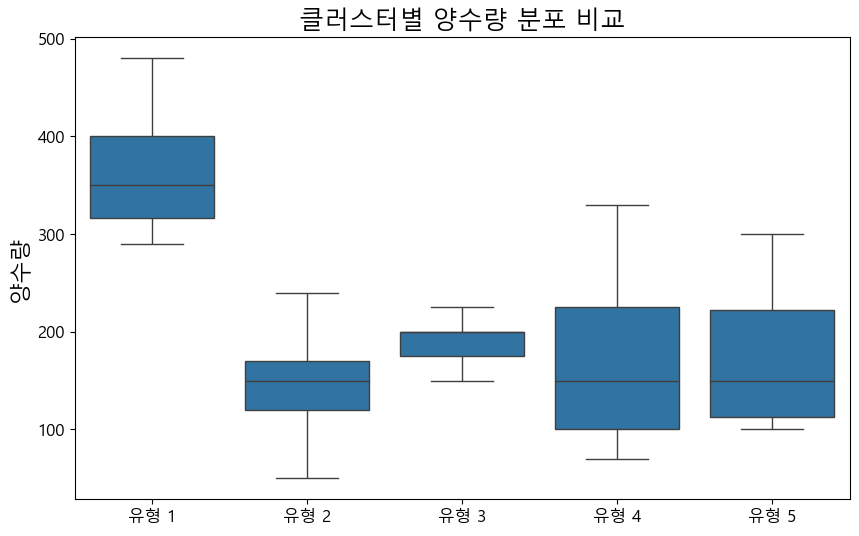

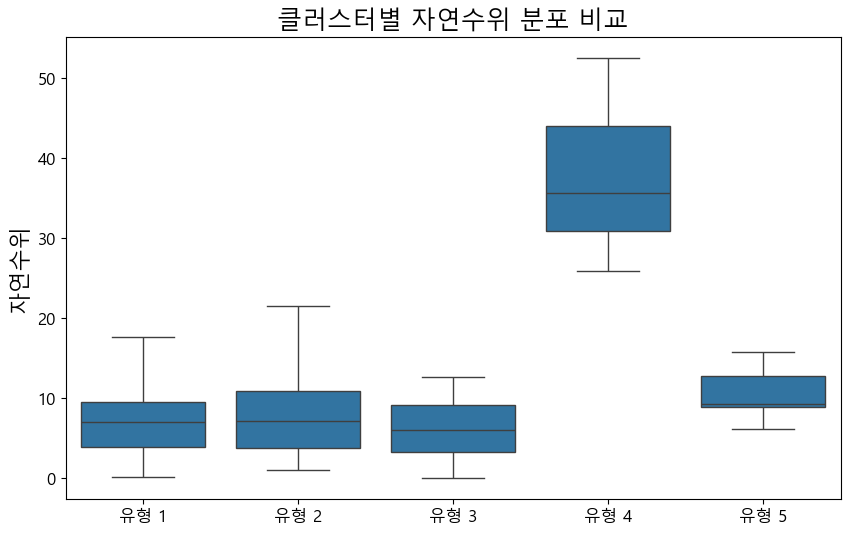

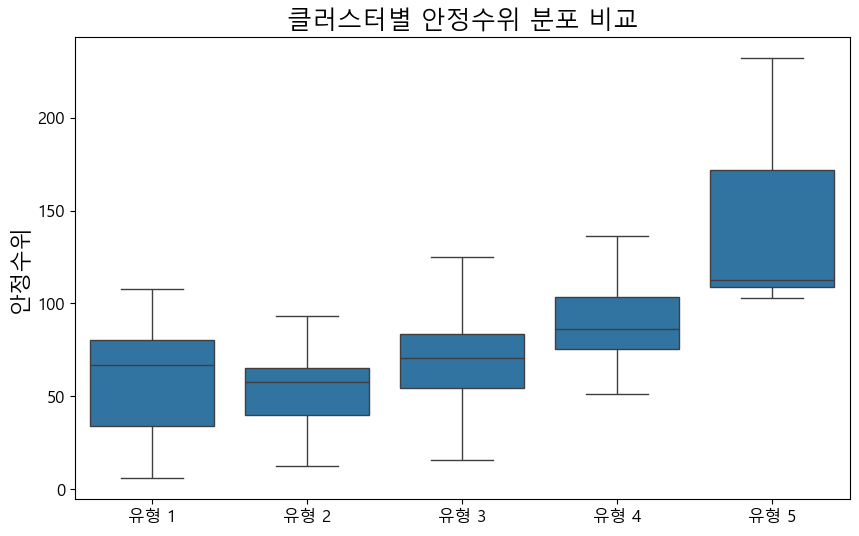

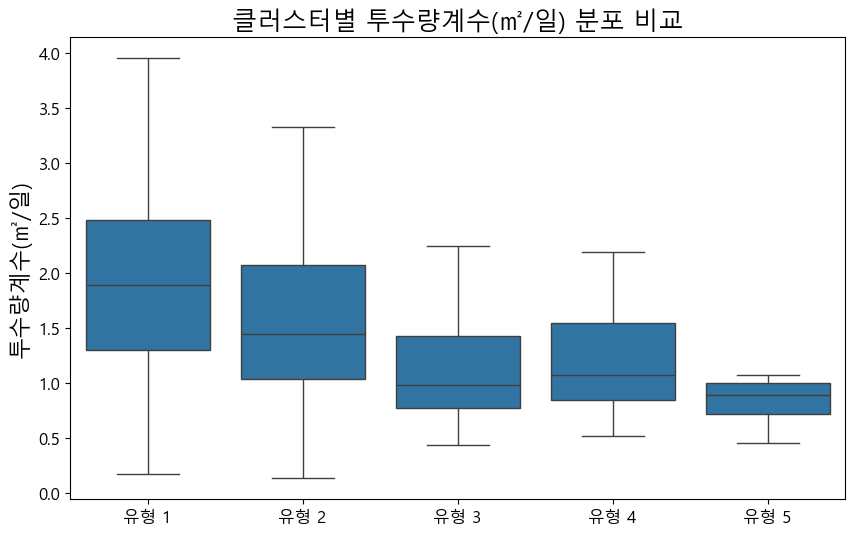

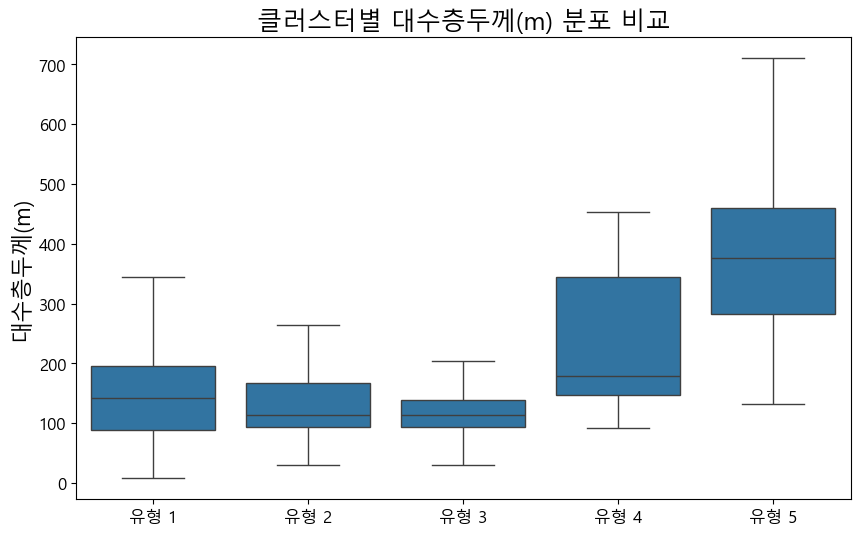

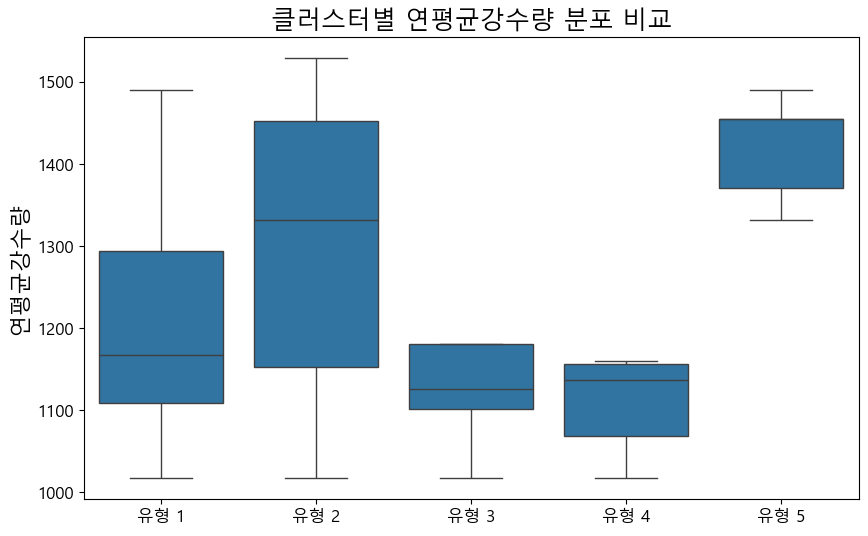

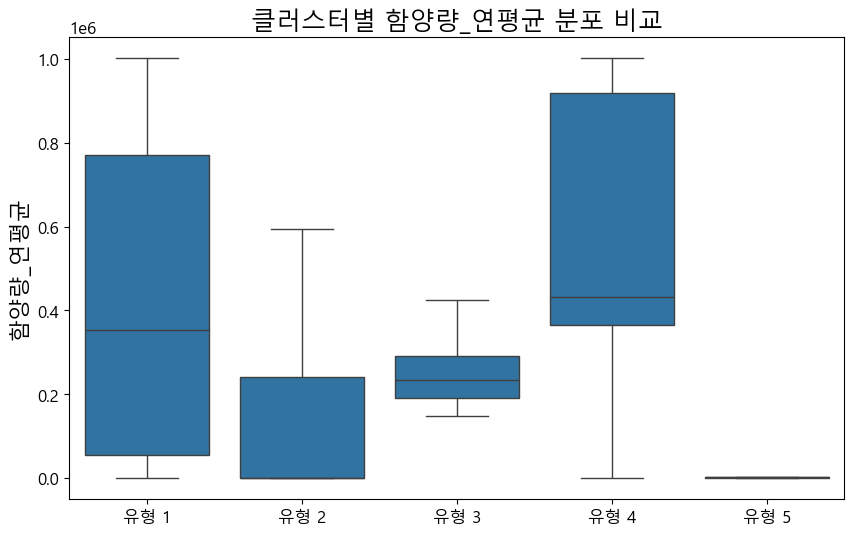


--- 3. 클러스터별 범주형 변수 구성 비율 ---


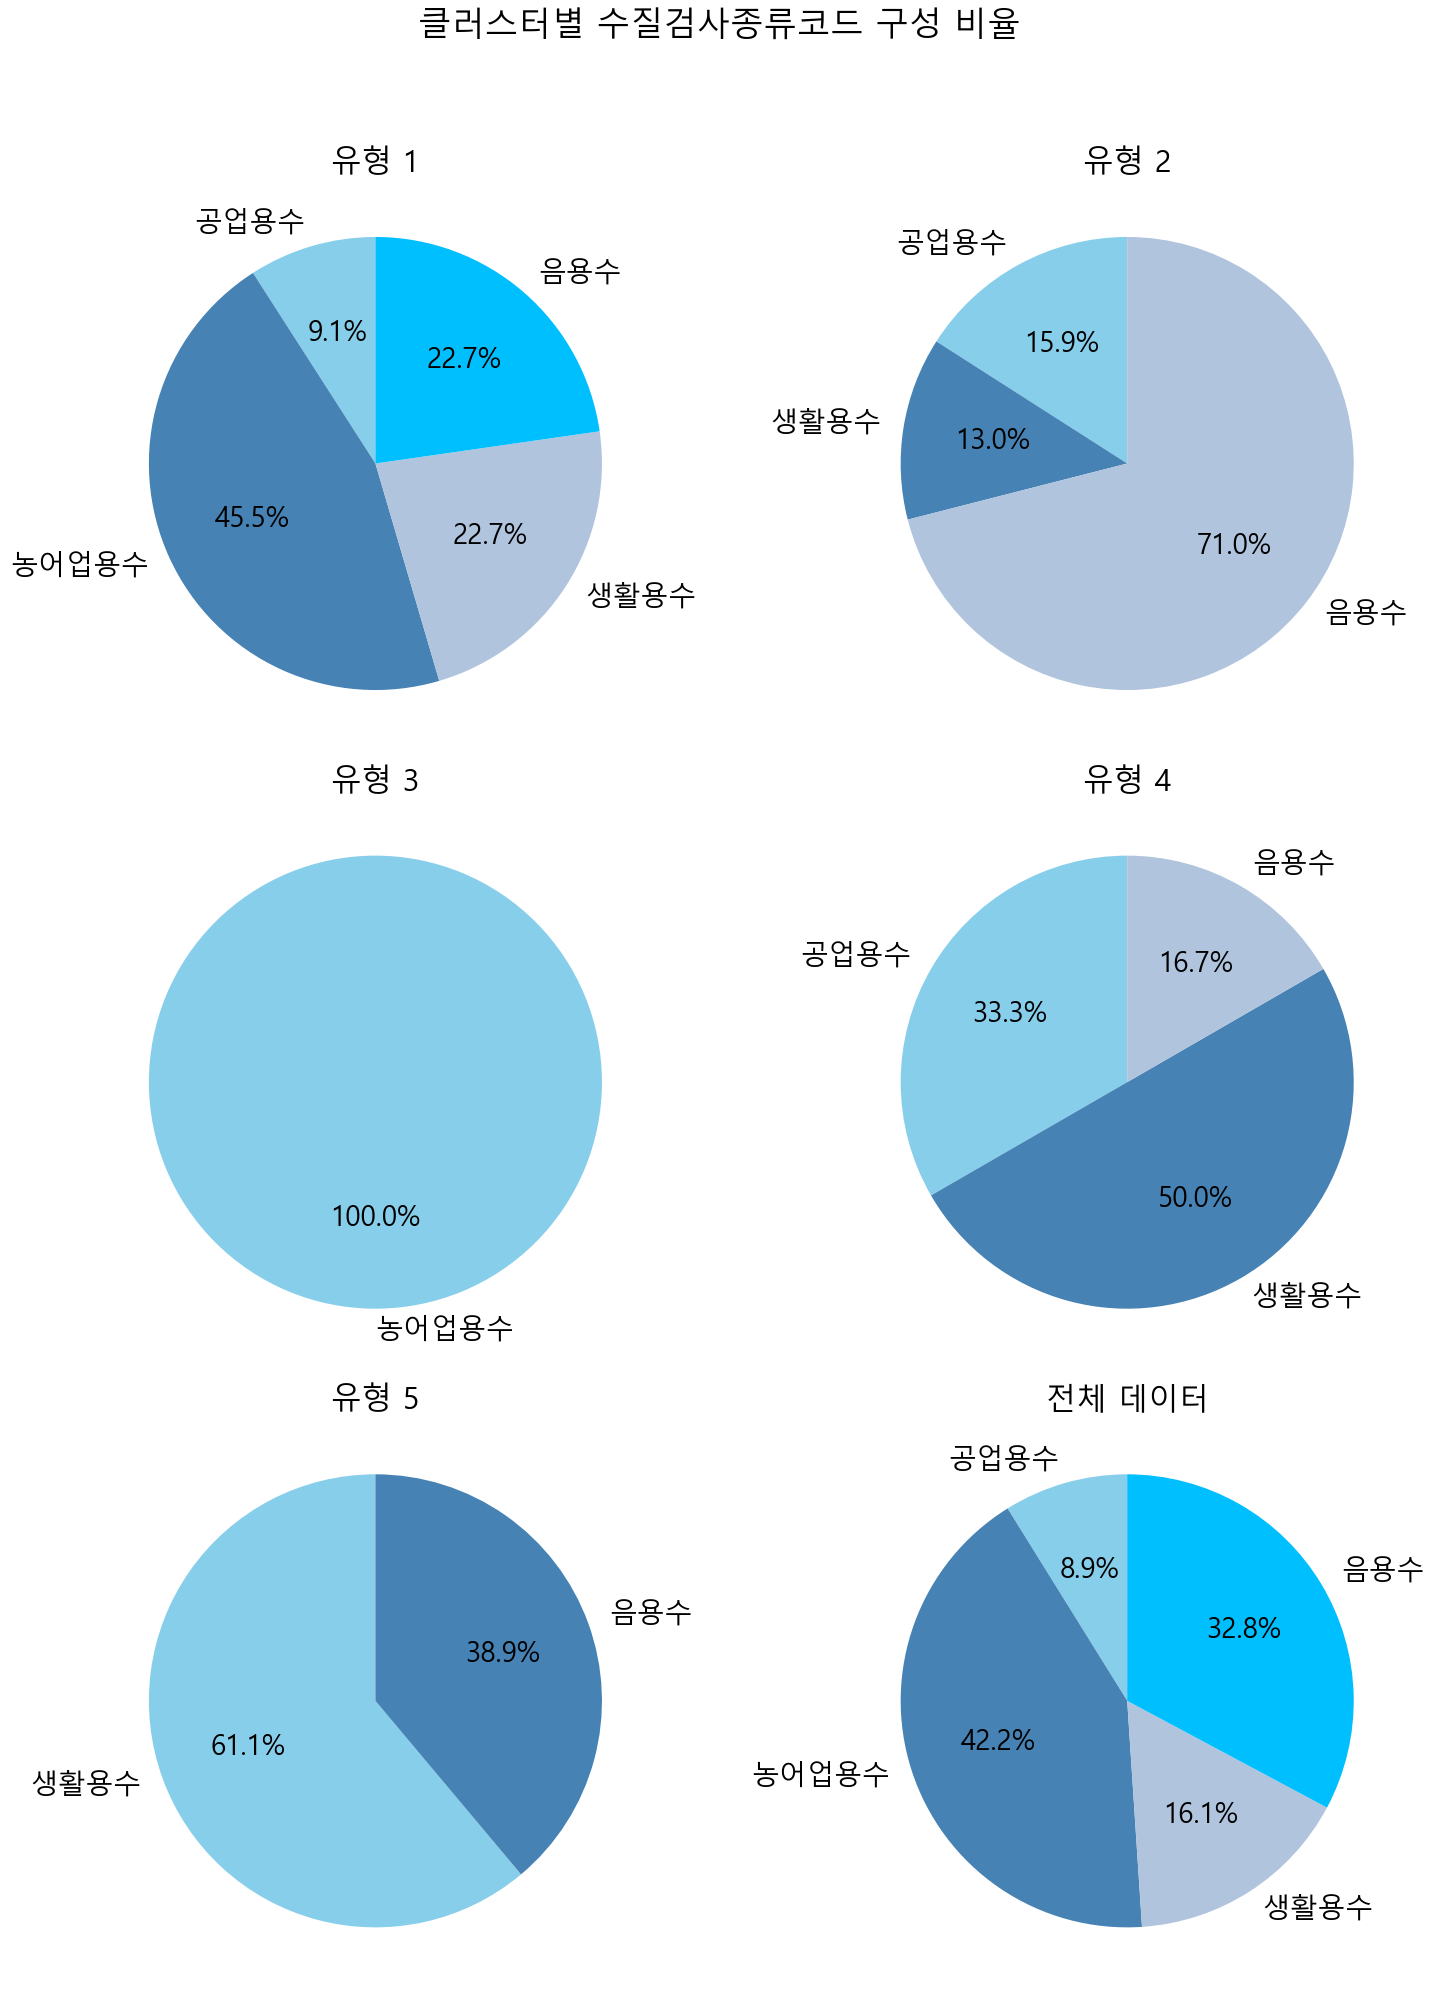

In [173]:
# 그래프의 모든 글자 크기를 전역적으로 키웁니다.
plt.rcParams.update({'font.size': 14,
                     'axes.labelsize': 16,
                     'axes.titlesize': 18,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12,
                     'legend.fontsize': 12,
                     'figure.titlesize': 20})


# 클러스터 라벨을 알아보기 쉽게 문자열로 변경합니다.
cluster_map = {0: '유형 1', 1: '유형 2', 2: '유형 3', 3: '유형 4', 4: '유형 5'}
df_cleaned['cluster_label'] = df_cleaned['cluster'].map(cluster_map)


# --- EDA 시작 ---

# 1. 클러스터별 데이터 개수 확인
print("--- 1. 클러스터별 데이터 개수 ---")
cluster_counts = df_cleaned['cluster_label'].value_counts().sort_index()
print(cluster_counts)
print("-" * 50)


# 2. 수치형 변수 특징 비교
print("--- 2. 클러스터별 수치형 변수 분포 비교 ---")
numeric_features = ['양수량', '자연수위', '안정수위', '투수량계수(㎡/일)',
                    '대수층두께(m)', '연평균강수량', '함양량_연평균']

# 2-1. 기술 통계량 비교
print("\n[클러스터별 기술 통계량]")
numeric_summary = df_cleaned.groupby('cluster_label')[numeric_features].describe()
print(numeric_summary)

# 2-2. Boxplot으로 시각적 비교
for feature in numeric_features:
    if feature in df_cleaned.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='cluster_label', y=feature, data=df_cleaned, showfliers=False,
                    order=sorted(cluster_map.values()))
        plt.title(f'클러스터별 {feature} 분포 비교')
        plt.xlabel("") # x축 라벨 제거
        plt.show()


# 3. 범주형 변수 특징 비교 (Pie Chart)
print("\n--- 3. 클러스터별 범주형 변수 구성 비율 ---")
categorical_features = ['수질검사종류코드']

for feature in categorical_features:
    if feature in df_cleaned.columns:
        crosstab_result = pd.crosstab(df_cleaned['cluster_label'], df_cleaned[feature])
        crosstab_result = crosstab_result.reindex(sorted(cluster_map.values()))

        total_counts = crosstab_result.sum(axis=0)
        
        n_labels = len(crosstab_result.index)
        # subplot 크기를 유동적으로 조절하기 위해 수정
        n_rows = (n_labels + 1 + 1) // 2 # 2열 기준으로 행 개수 계산
        fig, axes = plt.subplots(n_rows, 2, figsize=(15, 7 * n_rows), squeeze=False)
        fig.suptitle(f'클러스터별 {feature} 구성 비율', fontsize=24)
        
        axes = axes.flatten()
        
        colors = ['#87CEEB','#4682B4', '#B0C4DE', '#00BFFF', '#ADD8E6']
            
        for i, cluster_label in enumerate(crosstab_result.index):
            ax = axes[i]
            data_for_pie = crosstab_result.loc[cluster_label]
            data_for_pie = data_for_pie[data_for_pie > 0]
            
            ax.pie(data_for_pie, labels=data_for_pie.index, autopct='%1.1f%%', startangle=90, colors=colors,
                   textprops={'fontsize': 20})
            ax.set_title(cluster_label, fontsize=22)

        if n_labels < len(axes):
            ax = axes[n_labels]
            total_counts_filtered = total_counts[total_counts > 0]
            ax.pie(total_counts_filtered, labels=total_counts_filtered.index, autopct='%1.1f%%', startangle=90, colors=colors,
                   textprops={'fontsize': 20})
            ax.set_title('전체 데이터', fontsize=22)

        for i in range(n_labels + 1, len(axes)):
            axes[i].set_visible(False)
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

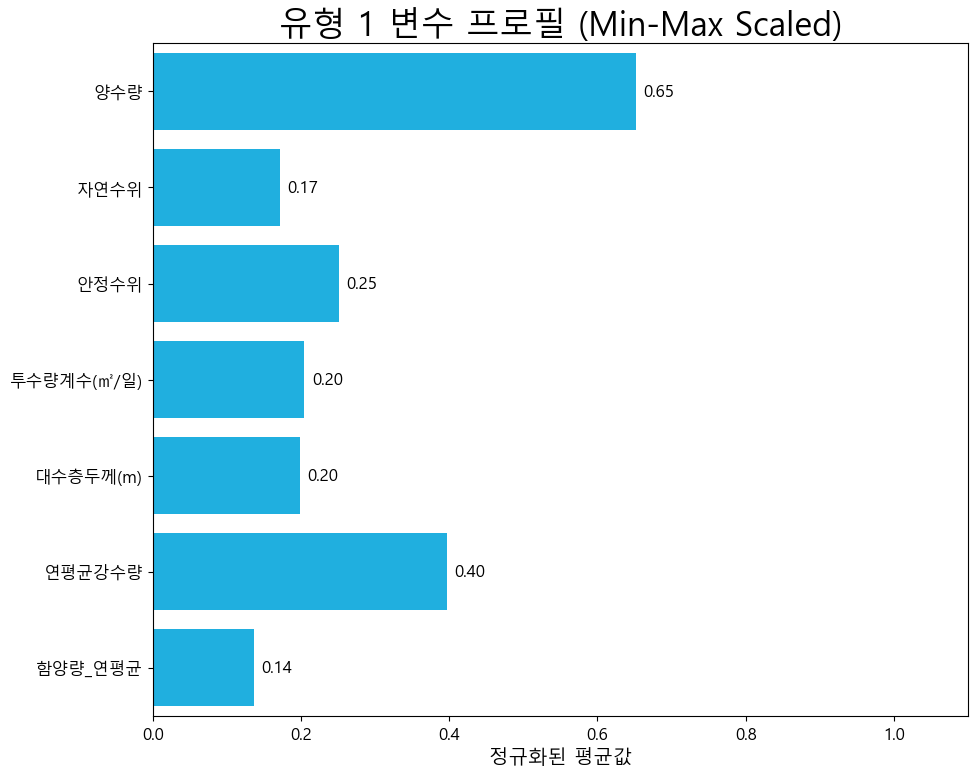

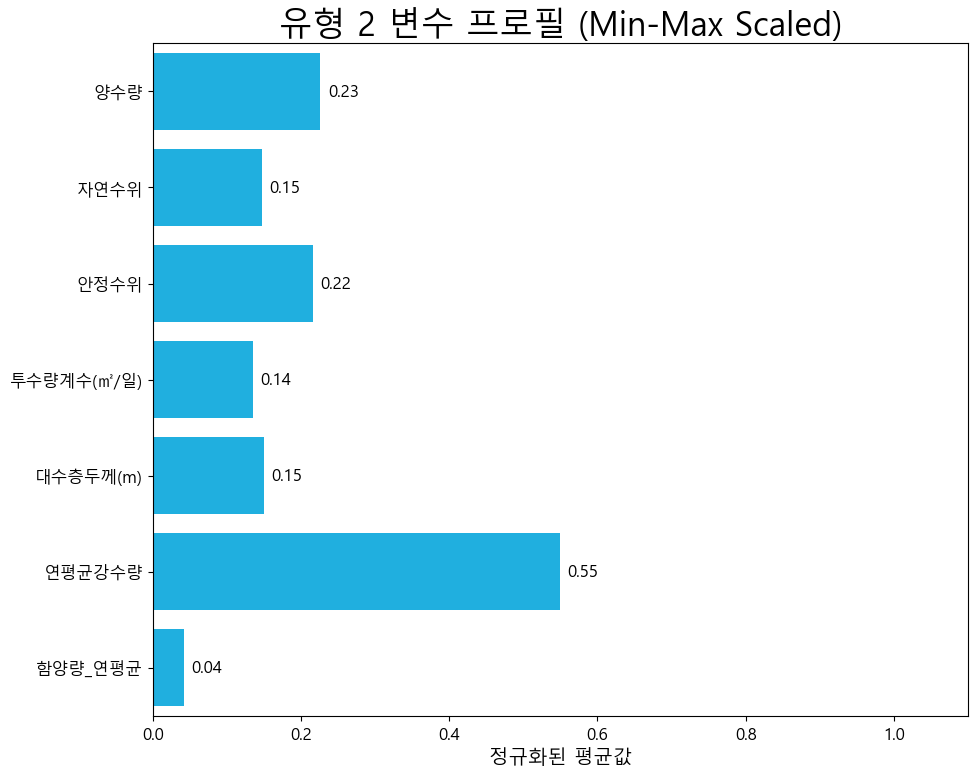

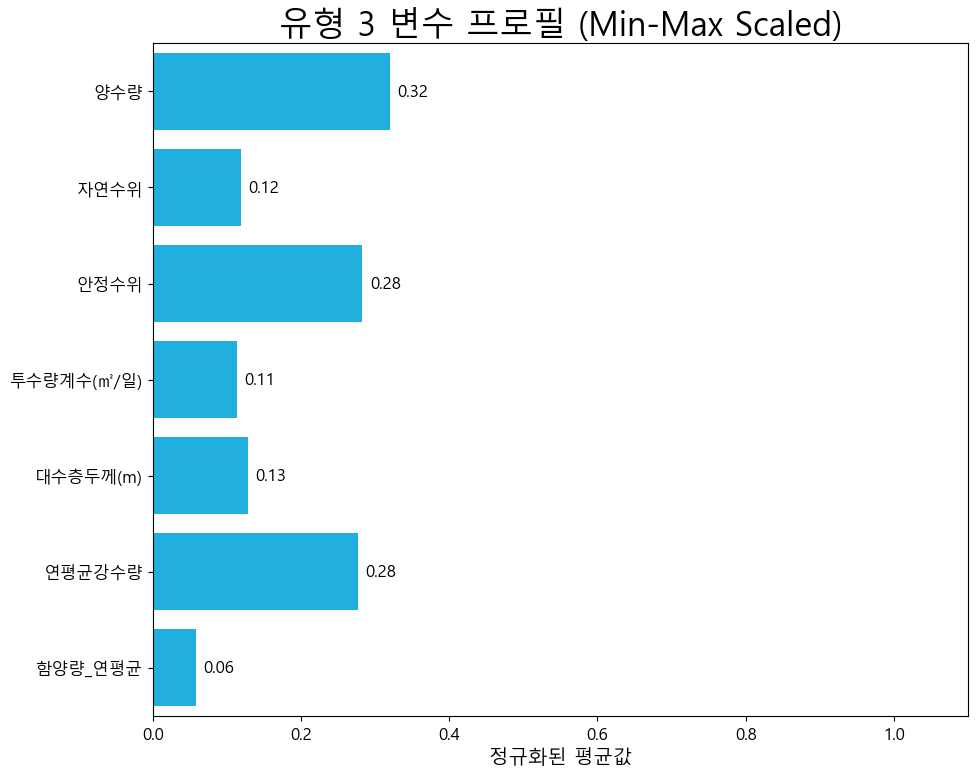

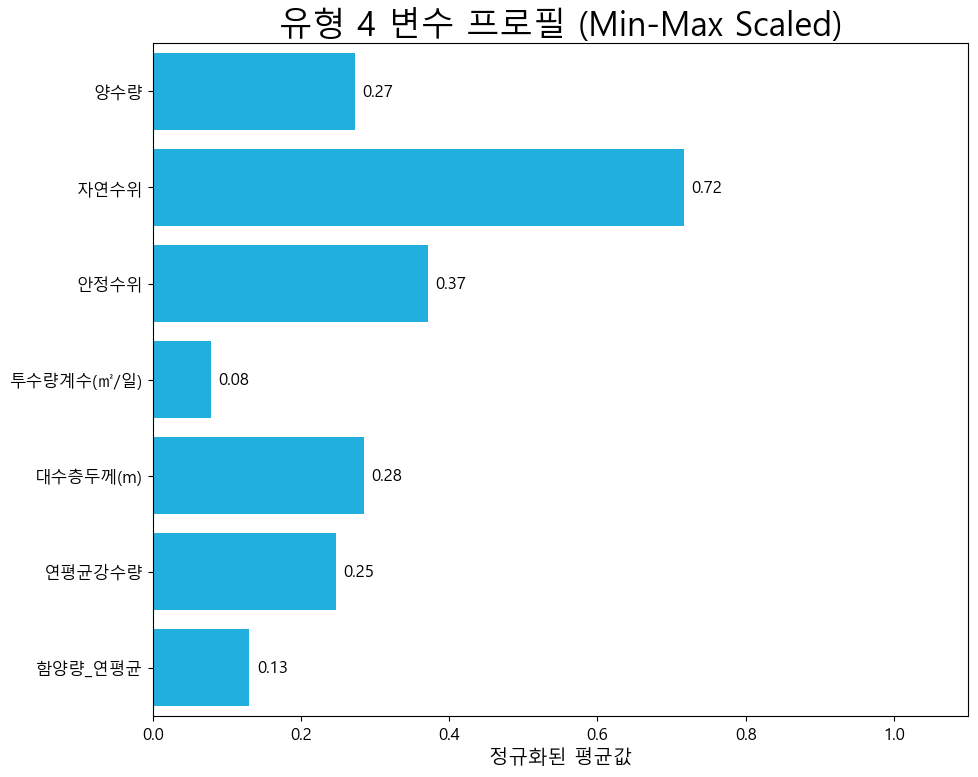

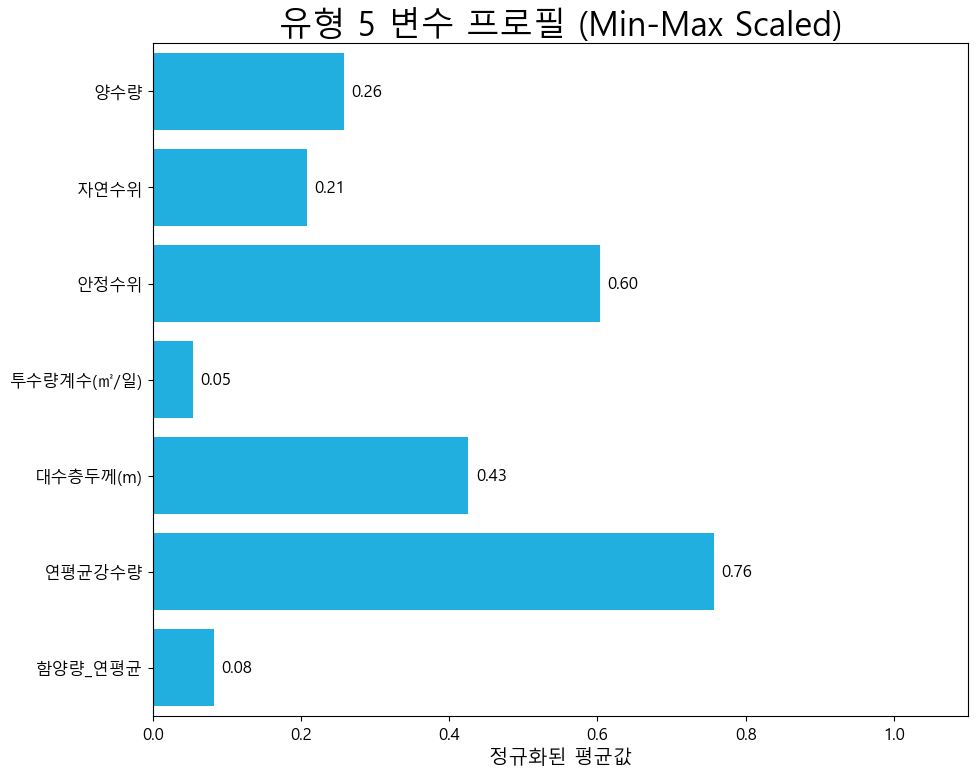

In [ ]:
# 클러스터 라벨을 '유형 1', '유형 2' 등으로 매핑
cluster_map = {0: '유형 1', 1: '유형 2', 2: '유형 3', 3: '유형 4', 4: '유형 5'}
df_cleaned['cluster_label'] = df_cleaned['cluster'].map(cluster_map)

# 분석에 사용할 수치형 변수 목록
numeric_features = ['양수량', '자연수위', '안정수위', '투수량계수(㎡/일)',
                    '대수층두께(m)', '연평균강수량', '함양량_연평균']

# 필요한 열만 선택하고 결측치 제거
df_for_viz = df_cleaned[['cluster_label'] + numeric_features].dropna()


# --- 2. 데이터 스케일링 (Min-Max Scaler) ---
scaler = MinMaxScaler()
# 수치형 변수들에 대해 스케일링 적용
df_for_viz[numeric_features] = scaler.fit_transform(df_for_viz[numeric_features])


# --- 3. 클러스터별 평균 계산 및 데이터 재구성 ---
# 각 클러스터의 변수별 평균을 계산합니다.
cluster_means = df_for_viz.groupby('cluster_label')[numeric_features].mean()

# 시각화를 위해 데이터를 'long' 형태로 변환합니다. (Melt)
df_melted = cluster_means.reset_index().melt(
    id_vars='cluster_label',
    var_name='variable',
    value_name='scaled_mean'
)


# --- 4. 시각화 (개별 가로 막대 그래프) ---
# 각 클러스터 라벨에 대해 반복하면서 개별 그래프를 생성합니다.
for cluster_name in df_melted['cluster_label'].unique():
    # 현재 클러스터에 해당하는 데이터만 필터링
    cluster_data = df_melted[df_melted['cluster_label'] == cluster_name]
    
    # 그래프 그릴 공간 생성
    plt.figure(figsize=(10, 8))
    
    # 가로 막대 그래프 생성
    ax = sns.barplot(
        data=cluster_data,
        y='variable',
        x='scaled_mean',
        color='#00BFFF' # DeepSkyBlue 색상으로 변경
    )
    
    # 그래프 디자인 개선
    plt.title(f'{cluster_name} 변수 ', fontsize=24)
    plt.xlabel("정규화된 평균값", fontsize=14)
    plt.ylabel("") # Y축 라벨 제거
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # 각 막대에 값(value)을 텍스트로 추가
    for p in ax.patches:
        ax.text(p.get_width() + 0.01,
                p.get_y() + p.get_height() / 2.,
                f'{p.get_width():.2f}',
                ha='left',
                va='center',
                fontsize=12)
    
    # x축의 범위를 약간 늘려 텍스트가 잘 보이도록 함
    ax.set_xlim(right=1.1)
    
    plt.tight_layout()
    plt.show()

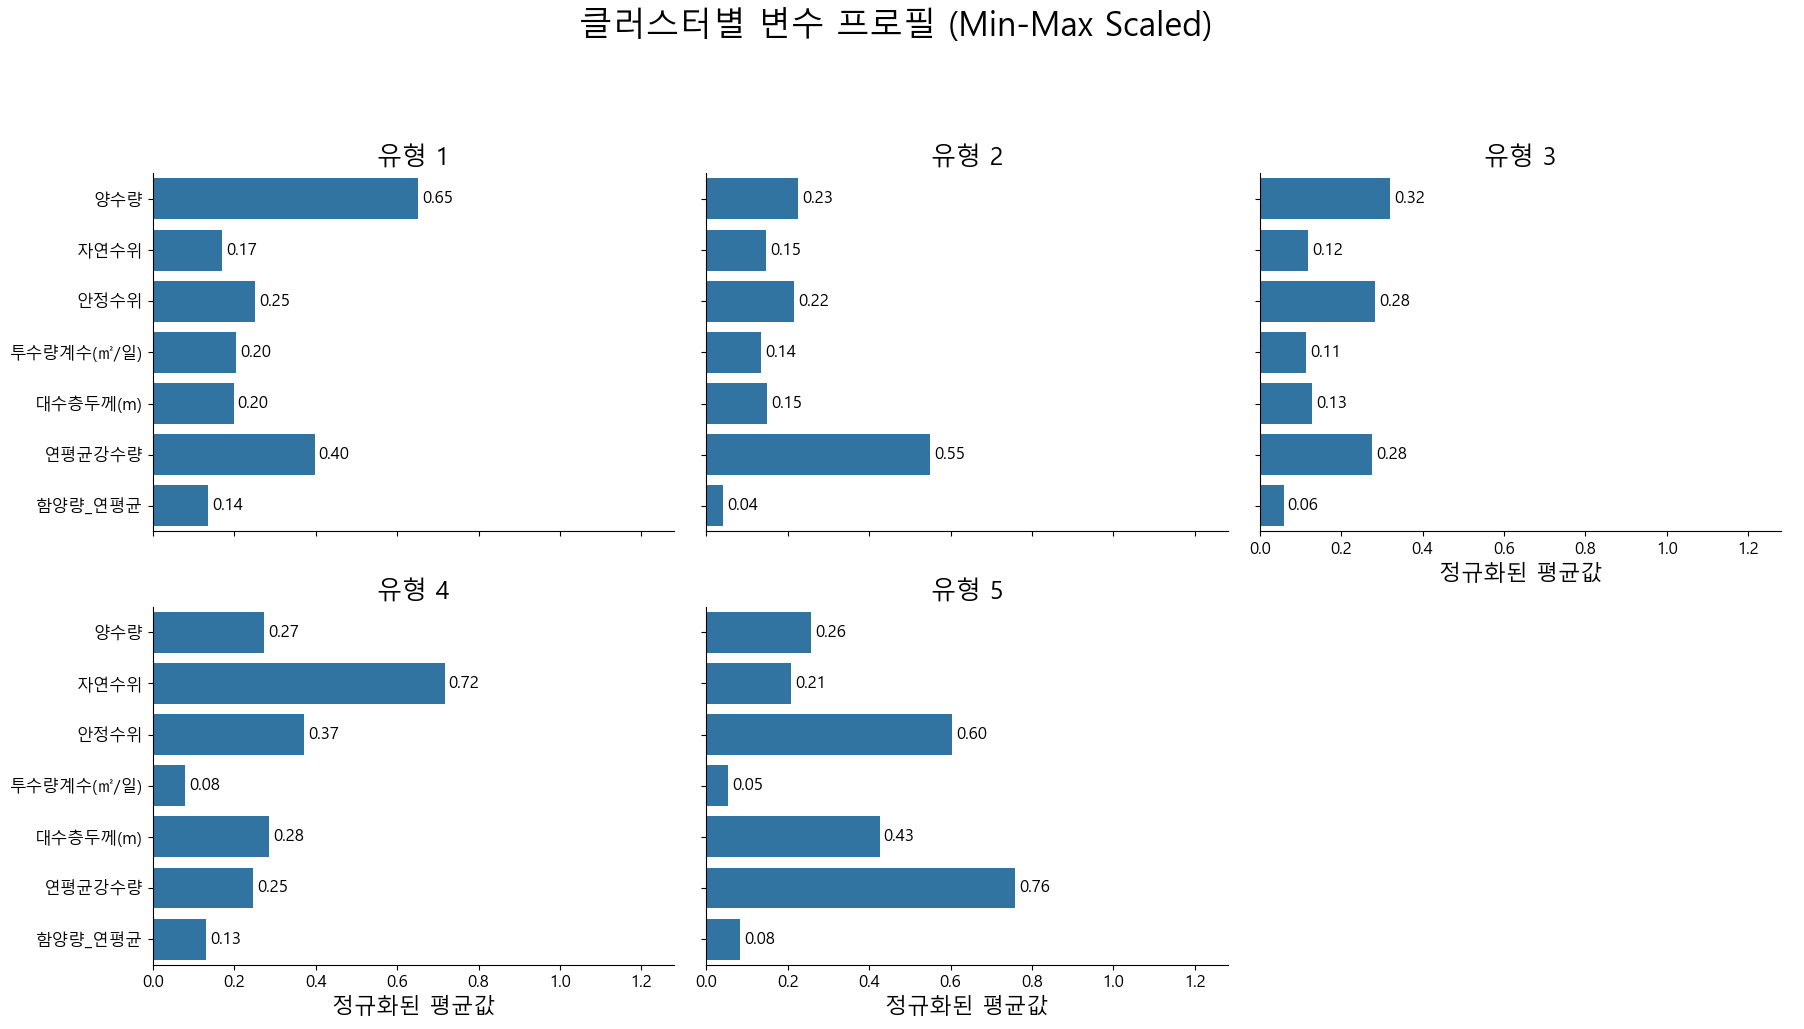

In [183]:
# 클러스터 라벨을 '유형 1', '유형 2' 등으로 매핑
cluster_map = {0: '유형 1', 1: '유형 2', 2: '유형 3', 3: '유형 4', 4: '유형 5'}
df_cleaned['cluster_label'] = df_cleaned['cluster'].map(cluster_map)

# 분석에 사용할 수치형 변수 목록
numeric_features = ['양수량', '자연수위', '안정수위', '투수량계수(㎡/일)',
                    '대수층두께(m)', '연평균강수량', '함양량_연평균']

# 필요한 열만 선택하고 결측치 제거
df_for_viz = df_cleaned[['cluster_label'] + numeric_features].dropna()


# --- 2. 데이터 스케일링 (Min-Max Scaler) ---
scaler = MinMaxScaler()
# 수치형 변수들에 대해 스케일링 적용
df_for_viz[numeric_features] = scaler.fit_transform(df_for_viz[numeric_features])


# --- 3. 클러스터별 평균 계산 및 데이터 재구성 ---
# 각 클러스터의 변수별 평균을 계산합니다.
cluster_means = df_for_viz.groupby('cluster_label')[numeric_features].mean()

# 시각화를 위해 데이터를 'long' 형태로 변환합니다. (Melt)
df_melted = cluster_means.reset_index().melt(
    id_vars='cluster_label',
    var_name='variable',
    value_name='scaled_mean'
)


# --- 4. 시각화 (Faceted Horizontal Bar Plot) ---
# catplot을 사용하여 각 클러스터별로 별도의 그래프를 그립니다.
g = sns.catplot(
    data=df_melted,
    y='variable',      # y축에 변수명을 두어 가로 막대 그래프로 변경
    x='scaled_mean',   # x축에 값을 두어 가로 막대 그래프로 변경
    col='cluster_label', # 'cluster_label' 값에 따라 열을 나눠서 그림
    kind='bar',
    col_wrap=3,        # 한 줄에 최대 3개의 그래프를 그림
    height=5,
    aspect=1.2
)

# 그래프 디자인 개선
g.fig.suptitle('클러스터별 변수 프로필 (Min-Max Scaled)', y=1.03, fontsize=24) # 제목 크기 키움
g.set_axis_labels("정규화된 평균값", "") # 축 라벨 변경
g.set_titles("{col_name}", size=18) # 각 subplot의 제목 크기 설정

# 각 막대에 값(value)을 텍스트로 추가하는 부분
for ax in g.axes.flat:
    # ax.patches는 그래프의 각 막대를 의미합니다.
    for p in ax.patches:
        ax.text(p.get_width() + 0.01, # 텍스트 x 위치 (막대 끝에서 약간 오른쪽)
                p.get_y() + p.get_height() / 2., # 텍스트 y 위치 (막대 중앙)
                f'{p.get_width():.2f}', # 표시할 텍스트 (값을 소수점 2자리까지)
                ha='left',   # 수평 정렬
                va='center', # 수직 정렬
                fontsize=12)
    # x축의 범위를 약간 늘려 텍스트가 잘 보이도록 함
    ax.set_xlim(right=ax.get_xlim()[1] * 1.1)


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
